<a href="https://colab.research.google.com/github/kato-taki/optimization-of-cultured-meat-production-system/blob/main/%E3%83%99%E3%82%A4%E3%82%BA%E6%9C%80%E9%81%A9%E5%8C%96_(Cglc0_%3D_18_65_mmol_L).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Input

## Import library


In [ ]:
#optunaのインストール
!pip install optuna

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import math
import time
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import pandas as pd
import random
import statistics
import csv
import optuna

## Parameter value and Constant value, experimental condition


In [ ]:
import csv

#===========================================================================#
# 動物細胞培養工程モジュール (C2C12マウス筋芽細胞)
#===========================================================================#
data_1 = [
    ("X0_cell", 3.664e8),
    ("Cglc0_cell", 18.6505),
    ("Clac0_cell", 8.5887),
    ("Cgln0_cell", 1.4236),
    ("Camm0_cell", 0.83965),
    ("umax_cell", 3.72897e-2),
    ("umin_cell", 0.005),
    ("qglc_cell_1", 2.67436e-8),
    ("qglc_cell_2", 2.02496e-8),
    ("qgln_cell", 3.89405e-10),
    ("qlac_cell_1", 3.95337e-8),
    ("qlac_cell_2", 2.99975e-8),
    ("qamm_cell", 1.47388e-10),
    ("Kgln", 0.1),
    ("Kamm_cell", 8.0),
    ("Kglc", 1.845038),
    ("Klac_cell", 115),
    ("kd_gln_37", 3.6505e-3)
]

#===========================================================================#
# 動物細胞の変動係数 (CV)
#===========================================================================#
data_2 = [
    ("CV_X0_cell", 8.648e-2),
    ("CV_X_count", 0.04),
    ("CV_Cglc0_cell", 1.701e-2),
    ("CV_Clac0_cell", 3.366e-2),
    ("CV_Cgln0_cell", 6.962e-2),
    ("CV_Camm0_cell", 0.1042),
    ("CV_umax_cell", 8.104e-2),
    ("CV_qglc_cell", 8.041e-2),
    ("CV_qlac_cell", 6.476e-2),
    ("CV_qgln_cell", 9.956e-2),
    ("CV_qamm_cell", 0.1323)
]

#===========================================================================#
# 藻類培養工程モジュール (synechococcus sp.)
#===========================================================================#
data_3 = [
    ("X0_algae", 4.667e10),
    ("Cglc0_algae", 18.6505),
    ("Clac0_algae", 34.7),
    ("Cgln0_algae", 1.4236),
    ("Camm0_algae", 2.94),
    ("umax_algae", 2.63534e-3),
    ('qglc_algae', 1.21806e-11),
    ('qgln_algae', -1.08162e-12),
    ('qlac_algae', 1.85181e-9),
    ('qamm_algae', 1.33483e-10),
    ("Kamm_algae", 0.019828),
    ("kd_gln_25", 1.2038e-3)
]

#===========================================================================#
# 藻類の変動係数 (CV)
#===========================================================================#
data_4 = [
    ("CV_X0_algae", 1.101e-2),
    ("CV_Cglc0_algae", 0.2072),
    ("CV_Clac0_algae", 4.389e-3),
    ("CV_Cgln0_algae", 0.1282),
    ("CV_Camm0_algae", 8.478e-2),
    ("CV_umax_algae", 0.1597),
    ("CV_qglc_algae", 2.4162),
    ("CV_qlac_algae", 0.2372),
    ("CV_qgln_algae", 1.192),
    ("CV_qamm_algae", 0.1778)
]

#===========================================================================#
# その他のパラメータ
#===========================================================================#
data_5 = [
    ("kglc", 7.7075099320995e-10),
    ("CV_kglc", 0.0993444775580169),
    ("k_hydrolysis", 0.05),
    ("V", 1),
    ("t_tot", 480),
    ("scale", 100)
]

# すべてのグループデータをグローバル変数として設定
for group in [data_1, data_2, data_3, data_4, data_5]:
    for item in group:
        globals()[item[0]] = item[1]

# CSVファイルに書き込む
output_file = 'model_parameters_with_sd_cv.csv'
with open(output_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["Parameter", "Value"])  # ヘッダー行の書き込み
    for group in [data_1, data_2, data_3, data_4, data_5]:
        writer.writerows(group)  # 各グループのパラメータをCSVに書き込む

print(f"Model parameters have been written to {output_file}")

Model parameters have been written to model_parameters_with_sd_cv.csv


# Process

## Definition of culture process function

In [ ]:
# 動物細胞培養プロセス
def cell_culture(t, y, qglc_cell, qlac_cell, dt):
    X, Cglc, Clac, Cgln, Camm = y

    # 比増殖速度
    u = umax_cell * (Cglc / ((Kglc + Cglc) * (1 + Clac / Klac_cell))) * (Cgln / ((Kgln + Cgln) * (1 + Camm / Kamm_cell)))

    # 増殖速度式
    dXdt = u * X

    # 代謝速度式
    # グルコース代謝
    dCglcdt = -qglc_cell * u * X
    if Cglc + dCglcdt * dt < 0:  # Cglcが負の値をとらないようにする制約
        dCglcdt = -Cglc / dt

    # 乳酸代謝
    dClacdt = qlac_cell * u * X

    # グルタミン代謝
    dCglndt = -qgln_cell * u * X - kd_gln_37 * Cgln
    if Cgln + dCglndt * dt < 0:  # Cglnが負の値をとらないようにする制約
        dCglndt = -Cgln / dt

    # アンモニア代謝
    dCammdt = qamm_cell * u * X + kd_gln_37 * Cgln

    return [dXdt, dCglcdt, dClacdt, dCglndt, dCammdt]

# 動物細胞の比増殖速度
def u_cell(Cglc, Clac, Cgln, Camm):
  u = umax_cell *(Cglc/((Kglc+Cglc)*(1+Clac/Klac_cell)))*(Cgln/((Kgln+Cgln)*(1+Camm/Kamm_cell)))
  return u


#藻類培養プロセス
def algae_culture(t,y,dt):
  X,Cglc,Clac,Cgln,Camm = y
  #比増殖速度
  u = umax_algae *(Camm/(Kamm_algae+Camm))
  #増殖速度式
  dXdt = u * X

  #代謝速度式
  #グルコース代謝
  dCglcdt = -qglc_algae * u * X
  # Cglcが負の値をとらないようにする制約
  if Cglc + dCglcdt * dt < 0:
    dCglcdt = -Cglc / dt

  #乳酸代謝
  dClacdt = -qlac_algae * u * X

  #グルタミン代謝
  dCglndt = -qgln_algae * u * X - kd_gln_25 * Cgln
  # Cglnが負の値をとらないようにする制約
  if Cgln + dCglndt * dt < 0:
    dCglndt = -Cgln / dt

  #アンモニア代謝
  dCammdt = -qamm_algae * u * X + kd_gln_25 * Cgln
  # Cammが負の値をとらないようにする制約
  if Camm + dCammdt * dt < 0:
    dCammdt = -Camm / dt

  return [dXdt, dCglcdt, dClacdt, dCglndt, dCammdt]

#藻類の比増殖速度
def u_algae(Camm):
  u = umax_algae *(Camm/(Kamm_algae+Camm))
  return u


#===============================================================================
#培地交換プロセス
#===============================================================================
#動物細胞培地
def exchange_cell(C_cell,C_algae,list_C,k_vol,r):
  C = (1-r*k_vol)*C_cell[-1] + r*k_vol*C_algae[-1]  #培地交換後の濃度
  list_C.append(C)
  return list_C

#藻類培地
def exchange_algae(C_cell,C_algae,list_C,k_vol,r):
  C = (1-r)*C_algae[-1] + r*C_cell[-1]  #培地交換後の濃度
  list_C.append(C)
  return list_C


#===============================================================================
#経時変化を出力する関数
#===============================================================================
#配列を初期化する関数
def initialize_array(array_list, shape=(2,)):
    return np.zeros((shape[0], len(array_list[-1])))

#リストから平均値を計算する関数
def calculate_mean(values_list, scale, i):
    return statistics.mean(values_list[j][i] for j in range(scale))

#リストから変動係数を計算する関数
def calculate_cv(values_list, mean_value, scale, i):
    if mean_value == 0:
        return 0  # 平均値がゼロの場合、CVをゼロに設定
    return statistics.stdev(values_list[j][i] for j in range(scale)) / mean_value

## Definition of CCC model

In [ ]:
##4. CCCモデルの定義．
def CCC_model(
    umax_cell,
    qglc_cell_1,
    qglc_cell_2,
    qlac_cell_1,
    qlac_cell_2,
    qgln_cell,
    qamm_cell,
    umax_algae,
    qglc_algae,
    qlac_algae,
    qgln_algae,
    qamm_algae,
    kglc,
    k_vol,
    r,
    t_cycle
):
  # 関数の内容をここに書く

  #=============================================================================
  #CCCモデルパラメータの初期値
  #=============================================================================
  #入力パラメータの乱数生成
  #入力パラメータと標準偏差の対応をまとめる
  param_rand = {
      'list_umax_cell':   (umax_cell,   umax_cell*CV_umax_cell),
      'list_umax_algae':  (umax_algae, umax_algae*CV_umax_algae),
      'list_qglc_cell_1': (qglc_cell_1,   qglc_cell_1*CV_qglc_cell),
      'list_qglc_cell_2': (qglc_cell_2,   qglc_cell_2*CV_qglc_cell),
      'list_qlac_cell_1': (qlac_cell_1,   qlac_cell_1*CV_qlac_cell),
      'list_qlac_cell_2': (qlac_cell_2,   qlac_cell_2*CV_qlac_cell),
      'list_qgln_cell':   (qgln_cell,   qgln_cell*CV_qgln_cell),
      'list_qamm_cell':   (qamm_cell,   qamm_cell*CV_qamm_cell),
      'list_qglc_algae':  (qglc_algae, qglc_algae*CV_qglc_algae),
      'list_qlac_algae':  (qlac_algae, qlac_algae*CV_qlac_algae),
      'list_qgln_algae':  (qgln_algae, qgln_algae*CV_qgln_algae),
      'list_qamm_algae':  (qamm_algae, qamm_algae*CV_qamm_algae),
      'list_kglc':        (kglc, kglc*CV_kglc)
  }


  # 乱数生成をまとめて実行
  # 乱数生成回数
  globals().update({
      name: [random.gauss(param, sd) for i in range(scale)]
      for name, (param, sd) in param_rand.items()
  })


  # モデルパラメータの経時変化を格納するリスト
  list_names = [
      # 動物細胞培養プロセスに関連するモデルパラメータ
      'list_X_cell', 'list_u_cell', 'list_Cglc_cell', 'list_Clac_cell',
      'list_Cgln_cell', 'list_Camm_cell',
      # 藻類培養プロセスに関連するモデルパラメータ
      'list_X_algae', 'list_u_algae', 'list_Cglc_algae', 'list_Clac_algae',
      'list_Cgln_algae', 'list_Camm_algae',
      # 培地交換後の濃度（動物細胞培養プロセス）
      'list_Cglc_cell_i', 'list_Clac_cell_i', 'list_Cgln_cell_i', 'list_Camm_cell_i',
      # 培地交換後の濃度（藻類培養プロセス）
      'list_Cglc_algae_i', 'list_Clac_algae_i', 'list_Cgln_algae_i', 'list_Camm_algae_i',
      # Output
      'list_N'
  ]

  # リストをまとめて初期化
  globals().update({name: [[] for i in range(scale)] for name in list_names})


  #=============================================================================
  #CCCモデルの実行
  #=============================================================================
  #サイクル数
  cycle_num = int(t_tot / t_cycle)

  for n in range(scale):
    # flag = Trueでシミュレーション
    flag = True
    # 比増殖速度の制限
    below_umin_time = 0       # u_cell < umin_cell の状態がどれだけ続いたか追跡するための変数
    umin_cell_threshold = 10  # 10時間を閾値として設定
    # サイクルΔtにおいて比増殖速度が閾値に達した時間
    umin_time = 0

    #乱数データから入力値を設定する
    umax_cell   =  list_umax_cell[n]
    umax_algae  =  list_umax_algae[n]
    qglc_cell_1 =  list_qglc_cell_1[n]
    qglc_cell_2 =  list_qglc_cell_2[n]
    qlac_cell_1 =  list_qlac_cell_1[n]
    qlac_cell_2 =  list_qlac_cell_2[n]
    qgln_cell   =  list_qgln_cell[n]
    qamm_cell   =  list_qamm_cell[n]
    qglc_algae  =  list_qglc_algae[n]
    qlac_algae  =  list_qlac_algae[n]
    qgln_algae  =  list_qgln_algae[n]
    qamm_algae  =  list_qamm_algae[n]
    kglc        =  list_kglc[n]


    for i in range(cycle_num):
      if flag == True:
        #===========================================================================
        #動物細胞培養プロセスの初期設定
        #===========================================================================
        # 1サイクル目の初期細胞密度と培地濃度の初期値の定義．
        if i == 0:
          #初期細胞密度
          X0 = random.gauss(X0_cell,X0_cell*CV_X0_cell)
          #培地濃度の初期値
          Cglc0 = random.gauss(Cglc0_cell,Cglc0_cell*CV_Cglc0_cell)
          Clac0 = random.gauss(Clac0_cell,Clac0_cell*CV_Clac0_cell)
          Cgln0 = random.gauss(Cgln0_cell,Cgln0_cell*CV_Cgln0_cell)
          Camm0 = random.gauss(Camm0_cell,Camm0_cell*CV_Camm0_cell)
          y0 = [X0, Cglc0, Clac0, Cgln0, Camm0]
        # 2サイクル目以降の初期細胞密度と培地濃度の初期値の定義．
        else:
          #初期細胞密度(セルカウントのCVを考慮する必要がある)
          X0 = random.gauss(list_X_cell[n][-1],list_X_cell[n][-1]*CV_X_count)
          #培地濃度
          Cglc0 = list_Cglc_cell_i[n][-1]
          Clac0 = list_Clac_cell_i[n][-1]
          Cgln0 = list_Cgln_cell_i[n][-1]
          Camm0 = list_Camm_cell_i[n][-1]
          y0 = [X0, Cglc0, Clac0, Cgln0, Camm0]


        #===========================================================================
        #動物細胞培養プロセスの実行
        #===========================================================================
        # 培養期間の定義
        dt = 0.1
        t_span = (0, t_cycle)  # 時間範囲
        t_eval = np.linspace(*t_span, int(t_cycle/dt))  # 評価する時間点

        # 増殖に伴うグルコース消費係数，乳酸生成係数
        if i == 0:  # 1サイクル目
          qglc_cell, qlac_cell = qglc_cell_1, qlac_cell_1
        elif list_Cglc_cell_i[n][-1] > 10:  # Cglc > 10 mmol/Lのとき
          qglc_cell, qlac_cell = qglc_cell_1, qlac_cell_1
        else:
          qglc_cell, qlac_cell = qglc_cell_2, qlac_cell_2

        sol = solve_ivp(lambda t, y: cell_culture(t,y,qglc_cell,qlac_cell,dt), t_span, y0, t_eval=t_eval)

        # 比増殖速度
        for x in range(len(sol.t)):
          list_u_cell[n].append(u_cell(sol.y[1][x],sol.y[2][x],sol.y[3][x],sol.y[4][x]))

        # 動物培養プロセスパラメータをリストに格納する
        list_X_cell[n].extend(sol.y[0])
        list_Cglc_cell[n].extend(sol.y[1])
        list_Clac_cell[n].extend(sol.y[2])
        list_Cgln_cell[n].extend(sol.y[3])
        list_Camm_cell[n].extend(sol.y[4])


        #===========================================================================
        #動物細胞抜き出し操作
        #===========================================================================
        #回収細胞数
        list_N[n].append(list_X_cell[n][-1]*r*k_vol*V)
        #抜き出し後の細胞密度
        list_X_cell[n][-1] = (1-r*k_vol) * list_X_cell[n][-1]


        #===========================================================================
        #藻類培養プロセスの初期設定
        #===========================================================================
        # 1サイクル目の初期細胞密度の定義．
        if i == 0:
          #初期細胞密度
          X0 = random.gauss(X0_algae,X0_algae*CV_X0_algae)
          #培地濃度の初期値
          Cglc0 = random.gauss(Cglc0_algae,Cglc0_algae*CV_Cglc0_algae)
          Clac0 = random.gauss(Clac0_algae,Clac0_algae*CV_Clac0_algae)
          Cgln0 = random.gauss(Cgln0_algae,Cgln0_algae*CV_Cgln0_algae)
          Camm0 = random.gauss(Camm0_algae,Camm0_algae*CV_Camm0_algae)
          y0 = [X0, Cglc0, Clac0, Cgln0, Camm0]
        # 2サイクル目以降の初期細胞密度と培地濃度の初期値の定義．
        else:
          #初期細胞密度(セルカウントのCVを考慮する必要がある)
          X0 = random.gauss(list_X_algae[n][-1],list_X_algae[n][-1]*CV_X_count)
          #培地濃度
          Cglc0 = list_Cglc_algae_i[n][-1]
          Clac0 = list_Clac_algae_i[n][-1]
          Cgln0 = list_Cgln_algae_i[n][-1]
          Camm0 = list_Camm_algae_i[n][-1]
          y0 = [X0, Cglc0, Clac0, Cgln0, Camm0]


        #===========================================================================
        #5. 藻類培養プロセスの実行
        #===========================================================================
        #藻類培養プロセスの計算
        sol = solve_ivp(lambda t, y: algae_culture(t, y, dt), t_span, y0, t_eval=t_eval)

        # 藻類培養プロセスパラメータをリストに格納する
        list_X_algae[n].extend(sol.y[0])
        list_Cglc_algae[n].extend(sol.y[1])
        list_Clac_algae[n].extend(sol.y[2])
        list_Cgln_algae[n].extend(sol.y[3])
        list_Camm_algae[n].extend(sol.y[4])

        # 比増殖速度
        for y in range(len(sol.t)):
          list_u_algae[n].append(u_algae(sol.y[4][y]))


        #===========================================================================
        #藻類栄養素抽出プロセス，藻類抜き出し操作
        #===========================================================================
        #酸加水分解反応（藻類培地にグルコースを添加）
        list_Cglc_algae[n][-1]  = list_Cglc_algae[n][-1] + r*(k_hydrolysis*kglc*list_X_algae[n][-1])
        #抜き出し後の細胞密度
        list_X_algae[n][-1] = (1-r)*list_X_algae[n][-1]


        #===========================================================================
        #培地交換プロセス
        #===========================================================================
        #動物細胞培地
        exchange_cell(list_Cglc_cell[n],list_Cglc_algae[n],list_Cglc_cell_i[n],k_vol,r)
        exchange_cell(list_Clac_cell[n],list_Clac_algae[n],list_Clac_cell_i[n],k_vol,r)
        exchange_cell(list_Cgln_cell[n],list_Cgln_algae[n],list_Cgln_cell_i[n],k_vol,r)
        exchange_cell(list_Camm_cell[n],list_Camm_algae[n],list_Camm_cell_i[n],k_vol,r)

        #藻類培地
        exchange_algae(list_Cglc_cell[n],list_Cglc_algae[n],list_Cglc_algae_i[n],k_vol,r)
        exchange_algae(list_Clac_cell[n],list_Clac_algae[n],list_Clac_algae_i[n],k_vol,r)
        exchange_algae(list_Cgln_cell[n],list_Cgln_algae[n],list_Cgln_algae_i[n],k_vol,r)
        exchange_algae(list_Camm_cell[n],list_Camm_algae[n],list_Camm_algae_i[n],k_vol,r)

        if flag == False:
          break


    #===========================================================================
    #培養期間Δtが480時間の約数でない場合，残り時間のプロセスを実行
    #===========================================================================
    if t_tot - t_cycle * cycle_num > 0 and flag == True:

      #===========================================================================
      #動物細胞培養プロセスの初期設定
      #===========================================================================
      #初期細胞密度(セルカウントのCVを考慮する必要がある)
      X0 = random.gauss(list_X_cell[n][-1],list_X_cell[n][-1]*CV_X_count)
      #培地濃度
      Cglc0 = list_Cglc_cell_i[n][-1]
      Clac0 = list_Clac_cell_i[n][-1]
      Cgln0 = list_Cgln_cell_i[n][-1]
      Camm0 = list_Camm_cell_i[n][-1]
      y0 = [X0, Cglc0, Clac0, Cgln0, Camm0]


      #===========================================================================
      #動物細胞培養プロセスの実行
      #===========================================================================
      #培養時間の定義
      t_span = (0, t_tot - t_cycle * cycle_num)  # 時間範囲
      t_eval = np.linspace(*t_span, int((t_tot - t_cycle * cycle_num)/dt))  # 評価する時間点
      if list_Cglc_cell_i[n][-1] > 10:  # Cglc > 10 mmol/Lのとき
        qglc_cell, qlac_cell = qglc_cell_1, qlac_cell_1
      else:
        qglc_cell, qlac_cell = qglc_cell_2, qlac_cell_2

      sol = solve_ivp(lambda t, y: cell_culture(t,y,qglc_cell,qlac_cell,dt), t_span, y0, t_eval=t_eval)

      # 比増殖速度
      for x in range(len(sol.t)):
        list_u_cell[n].append(u_cell(sol.y[1][x],sol.y[2][x],sol.y[3][x],sol.y[4][x]))

      # 動物培養プロセスパラメータをリストに格納する
      list_X_cell[n].extend(sol.y[0])
      list_Cglc_cell[n].extend(sol.y[1])
      list_Clac_cell[n].extend(sol.y[2])
      list_Cgln_cell[n].extend(sol.y[3])
      list_Camm_cell[n].extend(sol.y[4])


      #===========================================================================
      #動物細胞抜き出し操作
      #===========================================================================
      #回収細胞数
      list_N[n].append(list_X_cell[n][-1]*r*k_vol*V)
      #抜き出し後の細胞密度
      list_X_cell[n][-1] = (1-r*k_vol) * list_X_cell[n][-1]


      #===========================================================================
      #藻類培養プロセスの初期設定
      #===========================================================================
      #初期細胞密度(セルカウントのCVを考慮する必要がある)
      X0 = random.gauss(list_X_algae[n][-1],list_X_algae[n][-1]*CV_X_count)
      #培地濃度
      Cglc0 = list_Cglc_algae_i[n][-1]
      Clac0 = list_Clac_algae_i[n][-1]
      Cgln0 = list_Cgln_algae_i[n][-1]
      Camm0 = list_Camm_algae_i[n][-1]
      y0 = [X0, Cglc0, Clac0, Cgln0, Camm0]


      #===========================================================================
      #藻類培養プロセスの実行
      #===========================================================================
      #藻類培養プロセスの計算
      sol = solve_ivp(lambda t, y: algae_culture(t, y, dt), t_span, y0, t_eval=t_eval)

      # 藻類培養プロセスパラメータをリストに格納する
      list_X_algae[n].extend(sol.y[0])
      list_Cglc_algae[n].extend(sol.y[1])
      list_Clac_algae[n].extend(sol.y[2])
      list_Cgln_algae[n].extend(sol.y[3])
      list_Camm_algae[n].extend(sol.y[4])

      # 比増殖速度
      for y in range(len(sol.t)):
        list_u_algae[n].append(u_algae(sol.y[4][y]))


      #===========================================================================
      #藻類栄養素抽出プロセス
      #===========================================================================
      #酸加水分解反応（藻類培地にグルコースを添加）
      list_Cglc_algae[n][-1]  = list_Cglc_algae[n][-1] + r*(k_hydrolysis*kglc*list_X_algae[n][-1])
      #抜き出し後の細胞密度
      list_X_algae[n][-1] = (1-r)*list_X_algae[n][-1]


      #===========================================================================
      #培地交換プロセス
      #===========================================================================
      #動物細胞培地
      exchange_cell(list_Cglc_cell[n],list_Cglc_algae[n],list_Cglc_cell_i[n],k_vol,r)
      exchange_cell(list_Clac_cell[n],list_Clac_algae[n],list_Clac_cell_i[n],k_vol,r)
      exchange_cell(list_Cgln_cell[n],list_Cgln_algae[n],list_Cgln_cell_i[n],k_vol,r)
      exchange_cell(list_Camm_cell[n],list_Camm_algae[n],list_Camm_cell_i[n],k_vol,r)

      #藻類培地
      exchange_algae(list_Cglc_cell[n],list_Cglc_algae[n],list_Cglc_algae_i[n],k_vol,r)
      exchange_algae(list_Clac_cell[n],list_Clac_algae[n],list_Clac_algae_i[n],k_vol,r)
      exchange_algae(list_Cgln_cell[n],list_Cgln_algae[n],list_Cgln_algae_i[n],k_vol,r)
      exchange_algae(list_Camm_cell[n],list_Camm_algae[n],list_Camm_algae_i[n],k_vol,r)


  #===========================================================================
  #CCCモデルの出力
  #===========================================================================
  #最適化したいモデルの出力
  # サイクルごとの回収細胞密度の和 (Y_value), 最終サイクルの回収細胞密度の変動係数の平均値 (Y_CV)
  #1. Y_value
  Y_value = statistics.mean(sum(list_N[i]) for i in range(scale))

  #2. Y_CV
  # サイクルごとの回収細胞密度の変動係数は単調増加であるため，Y_CVが低下するとプロセスを通じてCVが低下する．
  Y_CV = statistics.stdev(list_N[i][-1] for i in range(scale))/statistics.mean(list_N[i][-1] for i in range(scale))

  return Y_value, Y_CV

---
# Output

## Bayesian optimization

In [ ]:
import optuna
from optuna.visualization import plot_optimization_history
import matplotlib.pyplot as plt
import csv

# Y_valueの基準値を設定
Y_value_ref = 1994607146 # 例えば、Y_value の目標値や最大値など
Y_CV_ref    = 0.196559325733075

# スコア計算関数
def calculate_score(Y_value, Y_CV, lambda_value):
    # Y_value を基準値で無次元化
    Y_value_norm = Y_value / Y_value_ref

    # Y_CV はそのまま使用（無次元）
    Y_CV_norm = Y_CV / Y_CV_ref

    # スコアの計算（無次元化された形式）
    score = -(Y_value_norm - lambda_value * Y_CV_norm)
    return score

# 目的関数の定義
def objective(trial, lambda_value):
    # Optunaで探索する変数の設定
    k_vol = trial.suggest_uniform('k_vol', 1, 4)  # k_volは1～4の範囲
    max_r = 1 / k_vol  # rの最大値をk_volから計算

    # rのサンプリング: 0 < r < 1/k_vol
    r = trial.suggest_uniform('r', 0, max_r)  # rの範囲を動的に設定

    t_cycle = trial.suggest_int('t_cycle', 24, 60)  # t_cycleは24～60

    # CCC_model関数の実行（ダミーデータを使用）
    Y_value, Y_CV = CCC_model(
        umax_cell, umax_algae, qglc_cell_1, qglc_cell_2, qlac_cell_1, qlac_cell_2, qgln_cell, qamm_cell,
        qglc_algae, qlac_algae, qgln_algae, qamm_algae, kglc, k_vol, r, t_cycle
    )

    # trial.user_attrs に結果を保存
    trial.set_user_attr('Y_value', Y_value)
    trial.set_user_attr('Y_CV', Y_CV)

    # スコアを計算
    score = calculate_score(Y_value, Y_CV, lambda_value)

    print(f"Lambda: {lambda_value}, k_vol: {k_vol}, r: {r}, t_cycle: {t_cycle}, Y_value: {Y_value}, Y_CV: {Y_CV}, Score: {score}")

    # スコア最小化
    return score

# すべてのトライアル結果をCSVに保存する
def save_trials(trial_results, lambda_value):
    csv_filename = f'trials_results_lambda_{lambda_value}.csv'
    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Trial', 'k_vol', 'r', 't_cycle', 'lambda_value', 'Y_value', 'Y_CV', 'Score'])
        for i, result in enumerate(trial_results):
            writer.writerow([i + 1, result['k_vol'], result['r'], result['t_cycle'], lambda_value, result['Y_value'], result['Y_CV'], result['score']])
        print(f"Trial results for Lambda = {lambda_value} saved to {csv_filename}")

# 各lambdaについて最適化
for lambda_value in [0.1, 0.5, 1, 2, 3]:  # Lambdaを1から10まで変更
    print(f"\n=== Running Optuna Optimization for Lambda = {lambda_value} ===\n")
    trial_results = []  # トライアル結果をリセット
    study = optuna.create_study(direction="minimize")  # Optuna Studyを初期化

    # 最適化を実行
    study.optimize(lambda trial: objective(trial, lambda_value), n_trials=1000)

    # トライアル結果を保存
    for trial in study.trials:
        trial_results.append({
            'k_vol': trial.params['k_vol'],
            'r': trial.params['r'],
            't_cycle': trial.params['t_cycle'],
            'Y_value': trial.user_attrs.get('Y_value', None),  # user_attrsから取得
            'Y_CV': trial.user_attrs.get('Y_CV', None),       # user_attrsから取得
            'score': trial.value
        })

    save_trials(trial_results, lambda_value)

[I 2025-01-24 02:23:44,455] A new study created in memory with name: no-name-564b6ef1-42f8-45db-b141-907e13238722



=== Running Optuna Optimization for Lambda = 1 ===



<ipython-input-29-6cc0bad8ef43>:25: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  k_vol = trial.suggest_uniform('k_vol', 1, 4)  # k_volは1～4の範囲
<ipython-input-29-6cc0bad8ef43>:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  r = trial.suggest_uniform('r', 0, max_r)  # rの範囲を動的に設定
[I 2025-01-24 02:23:48,127] Trial 0 finished with value: 5.759847875455047 and parameters: {'k_vol': 2.3366624373387004, 'r': 0.42656282036776505, 't_cycle': 39}. Best is trial 0 with value: 5.759847875455047.


Lambda: 1, k_vol: 2.3366624373387004, r: 0.42656282036776505, t_cycle: 39, Y_value: 363992329.8211824, Y_CV: 1.1680215783845764, Score: 5.759847875455047


[I 2025-01-24 02:23:55,997] Trial 1 finished with value: 0.8228259333262921 and parameters: {'k_vol': 3.9297601420885346, 'r': 0.012043630229925158, 't_cycle': 50}. Best is trial 1 with value: 0.8228259333262921.


Lambda: 1, k_vol: 3.9297601420885346, r: 0.012043630229925158, t_cycle: 50, Y_value: 212628147.14812642, Y_CV: 0.18268763291112766, Score: 0.8228259333262921


[I 2025-01-24 02:23:59,520] Trial 2 finished with value: 0.1579020278665324 and parameters: {'k_vol': 2.389997853429998, 'r': 0.058029571321690634, 't_cycle': 31}. Best is trial 2 with value: 0.1579020278665324.


Lambda: 1, k_vol: 2.389997853429998, r: 0.058029571321690634, t_cycle: 31, Y_value: 1081854882.471707, Y_CV: 0.13764892019617228, Score: 0.1579020278665324


[I 2025-01-24 02:24:02,730] Trial 3 finished with value: 0.24490932556117384 and parameters: {'k_vol': 2.6894439105662027, 'r': 0.1550244104100802, 't_cycle': 48}. Best is trial 2 with value: 0.1579020278665324.


Lambda: 1, k_vol: 2.6894439105662027, r: 0.1550244104100802, t_cycle: 48, Y_value: 1679515999.504654, Y_CV: 0.21364775982568252, Score: 0.24490932556117384


[I 2025-01-24 02:24:04,455] Trial 4 finished with value: 1.3186238325273019 and parameters: {'k_vol': 2.814183553076763, 'r': 0.08811364749163234, 't_cycle': 34}. Best is trial 2 with value: 0.1579020278665324.


Lambda: 1, k_vol: 2.814183553076763, r: 0.08811364749163234, t_cycle: 34, Y_value: 1583348074.02899, Y_CV: 0.41521945426771695, Score: 1.3186238325273019


[I 2025-01-24 02:24:06,213] Trial 5 finished with value: 0.06907917175710032 and parameters: {'k_vol': 3.793403500390538, 'r': 0.0865249928182427, 't_cycle': 39}. Best is trial 5 with value: 0.06907917175710032.


Lambda: 1, k_vol: 3.793403500390538, r: 0.0865249928182427, t_cycle: 39, Y_value: 1895170415.3953154, Y_CV: 0.20033845042443277, Score: 0.06907917175710032


[I 2025-01-24 02:24:10,275] Trial 6 finished with value: 3.7344231889713457 and parameters: {'k_vol': 3.1624092837460784, 'r': 0.30379759744796875, 't_cycle': 44}. Best is trial 5 with value: 0.06907917175710032.


Lambda: 1, k_vol: 3.1624092837460784, r: 0.30379759744796875, t_cycle: 44, Y_value: 378324627.2845698, Y_CV: 0.7713178494332972, Score: 3.7344231889713457


[I 2025-01-24 02:24:11,812] Trial 7 finished with value: 2.6391002766468468 and parameters: {'k_vol': 1.0533492199430121, 'r': 0.9487984202821863, 't_cycle': 27}. Best is trial 5 with value: 0.06907917175710032.


Lambda: 1, k_vol: 1.0533492199430121, r: 0.9487984202821863, t_cycle: 27, Y_value: 397026821.48670036, Y_CV: 0.5578649312229829, Score: 2.6391002766468468


[I 2025-01-24 02:24:13,998] Trial 8 finished with value: 0.4550450533639264 and parameters: {'k_vol': 1.7574806072011258, 'r': 0.05151086796787068, 't_cycle': 51}. Best is trial 5 with value: 0.06907917175710032.


Lambda: 1, k_vol: 1.7574806072011258, r: 0.05151086796787068, t_cycle: 51, Y_value: 388302753.5036297, Y_CV: 0.12770879254737516, Score: 0.4550450533639264


[I 2025-01-24 02:24:16,181] Trial 9 finished with value: 0.21323962623121406 and parameters: {'k_vol': 3.8821718832812815, 'r': 0.04634441582871615, 't_cycle': 48}. Best is trial 5 with value: 0.06907917175710032.


Lambda: 1, k_vol: 3.8821718832812815, r: 0.04634441582871615, t_cycle: 48, Y_value: 881893980.5435412, Y_CV: 0.12882081749313903, Score: 0.21323962623121406


[I 2025-01-24 02:24:19,864] Trial 10 finished with value: 0.31655701440680384 and parameters: {'k_vol': 3.477982388276128, 'r': 0.14798503414658837, 't_cycle': 60}. Best is trial 5 with value: 0.06907917175710032.


Lambda: 1, k_vol: 3.477982388276128, r: 0.14798503414658837, t_cycle: 60, Y_value: 1490360874.8297098, Y_CV: 0.20909041697148997, Score: 0.31655701440680384


[I 2025-01-24 02:24:23,537] Trial 11 finished with value: 1.8403344889978854 and parameters: {'k_vol': 2.2428095652577227, 'r': 0.23276069993930515, 't_cycle': 29}. Best is trial 5 with value: 0.06907917175710032.


Lambda: 1, k_vol: 2.2428095652577227, r: 0.23276069993930515, t_cycle: 29, Y_value: 842661267.6166122, Y_CV: 0.44477528388907056, Score: 1.8403344889978854


[I 2025-01-24 02:24:25,483] Trial 12 finished with value: 1.9024642055233727 and parameters: {'k_vol': 1.7200529006950613, 'r': 0.3146436187897787, 't_cycle': 35}. Best is trial 5 with value: 0.06907917175710032.


Lambda: 1, k_vol: 1.7200529006950613, r: 0.3146436187897787, t_cycle: 35, Y_value: 982830107.4971387, Y_CV: 0.4708004511298806, Score: 1.9024642055233727


[I 2025-01-24 02:24:27,028] Trial 13 finished with value: 0.4723797137978506 and parameters: {'k_vol': 3.2614355720040242, 'r': 0.11376553955710413, 't_cycle': 33}. Best is trial 5 with value: 0.06907917175710032.


Lambda: 1, k_vol: 3.2614355720040242, r: 0.11376553955710413, t_cycle: 33, Y_value: 1896450072.3695865, Y_CV: 0.27973703732276683, Score: 0.4723797137978506


[I 2025-01-24 02:24:28,668] Trial 14 finished with value: 0.8735726551329607 and parameters: {'k_vol': 1.9254292009510867, 'r': 0.22028129766721932, 't_cycle': 24}. Best is trial 5 with value: 0.06907917175710032.


Lambda: 1, k_vol: 1.9254292009510867, r: 0.22028129766721932, t_cycle: 24, Y_value: 1081350688.4606588, Y_CV: 0.27827097014655255, Score: 0.8735726551329607


[I 2025-01-24 02:24:30,760] Trial 15 finished with value: 0.7458333376250508 and parameters: {'k_vol': 2.86760987999141, 'r': 0.006350531118167982, 't_cycle': 42}. Best is trial 5 with value: 0.06907917175710032.


Lambda: 1, k_vol: 2.86760987999141, r: 0.006350531118167982, t_cycle: 42, Y_value: 83179754.32290341, Y_CV: 0.15479747872527855, Score: 0.7458333376250508


[I 2025-01-24 02:24:33,489] Trial 16 finished with value: 2.4942705658833915 and parameters: {'k_vol': 1.114026886836412, 'r': 0.697427894384067, 't_cycle': 39}. Best is trial 5 with value: 0.06907917175710032.


Lambda: 1, k_vol: 1.114026886836412, r: 0.697427894384067, t_cycle: 39, Y_value: 431300561.89681405, Y_CV: 0.5327748198149997, Score: 2.4942705658833915


[I 2025-01-24 02:24:36,152] Trial 17 finished with value: 0.19753548833956747 and parameters: {'k_vol': 3.563077546922948, 'r': 0.076402537346106, 't_cycle': 30}. Best is trial 5 with value: 0.06907917175710032.


Lambda: 1, k_vol: 3.563077546922948, r: 0.076402537346106, t_cycle: 30, Y_value: 1790678911.0086873, Y_CV: 0.2152905820467895, Score: 0.19753548833956747


[I 2025-01-24 02:24:38,000] Trial 18 finished with value: -0.16265330355978058 and parameters: {'k_vol': 2.1074251698333137, 'r': 0.175191157453535, 't_cycle': 38}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 2.1074251698333137, r: 0.175191157453535, t_cycle: 38, Y_value: 1611461472.8095512, Y_CV: 0.12683106483328177, Score: -0.16265330355978058


[I 2025-01-24 02:24:41,545] Trial 19 finished with value: 0.765889456519674 and parameters: {'k_vol': 1.5165056145678257, 'r': 0.45788942278335026, 't_cycle': 56}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 1.5165056145678257, r: 0.45788942278335026, t_cycle: 56, Y_value: 671118304.626339, Y_CV: 0.21667832572781484, Score: 0.765889456519674


[I 2025-01-24 02:24:42,989] Trial 20 finished with value: 0.33053739639280666 and parameters: {'k_vol': 2.0322675093601634, 'r': 0.1581492389708877, 't_cycle': 37}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 2.0322675093601634, r: 0.1581492389708877, t_cycle: 37, Y_value: 1555672810.0248935, Y_CV: 0.21827458111594458, Score: 0.33053739639280666


[I 2025-01-24 02:24:45,651] Trial 21 finished with value: 0.005990705989842748 and parameters: {'k_vol': 2.4987201689538034, 'r': 0.09845576816423547, 't_cycle': 43}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 2.4987201689538034, r: 0.09845576816423547, t_cycle: 43, Y_value: 1279696387.1637495, Y_CV: 0.12728570010915666, Score: 0.005990705989842748


[I 2025-01-24 02:24:50,333] Trial 22 finished with value: 0.15298220272248086 and parameters: {'k_vol': 2.5462014963788615, 'r': 0.11357426386905622, 't_cycle': 43}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 2.5462014963788615, r: 0.11357426386905622, t_cycle: 43, Y_value: 1715928519.4359808, Y_CV: 0.19916691227743485, Score: 0.15298220272248086


[I 2025-01-24 02:24:52,016] Trial 23 finished with value: -0.12862589109122946 and parameters: {'k_vol': 2.0829761244782756, 'r': 0.17765154591430848, 't_cycle': 40}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 2.0829761244782756, r: 0.17765154591430848, t_cycle: 40, Y_value: 1578472521.82865, Y_CV: 0.1302685612655035, Score: -0.12862589109122946


[I 2025-01-24 02:24:53,657] Trial 24 finished with value: 0.8479913008397799 and parameters: {'k_vol': 2.1259930229486157, 'r': 0.19621825109898977, 't_cycle': 42}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 2.1259930229486157, r: 0.19621825109898977, t_cycle: 42, Y_value: 1612104891.0040443, Y_CV: 0.32554609272242746, Score: 0.8479913008397799


[I 2025-01-24 02:24:55,593] Trial 25 finished with value: 0.6896425823798599 and parameters: {'k_vol': 1.6383363539863438, 'r': 0.29156015758319365, 't_cycle': 46}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 1.6383363539863438, r: 0.29156015758319365, t_cycle: 46, Y_value: 1368557514.263162, Y_CV: 0.27042070579890404, Score: 0.6896425823798599


[I 2025-01-24 02:24:57,918] Trial 26 finished with value: 1.2135401491115478 and parameters: {'k_vol': 1.4732927971980811, 'r': 0.38809282678893514, 't_cycle': 36}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 1.4732927971980811, r: 0.38809282678893514, t_cycle: 36, Y_value: 821635344.3375165, Y_CV: 0.31950100339895476, Score: 1.2135401491115478


[I 2025-01-24 02:25:01,694] Trial 27 finished with value: 1.1960704303395397 and parameters: {'k_vol': 2.534743203742269, 'r': 0.18466336905842487, 't_cycle': 53}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 2.534743203742269, r: 0.18466336905842487, t_cycle: 53, Y_value: 1495002962.6886613, Y_CV: 0.38242443730778913, Score: 1.1960704303395397


[I 2025-01-24 02:25:04,330] Trial 28 finished with value: 0.2516829973788708 and parameters: {'k_vol': 2.9923864161577702, 'r': 0.1293027856489221, 't_cycle': 45}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 2.9923864161577702, r: 0.1293027856489221, t_cycle: 45, Y_value: 1790035026.1203656, Y_CV: 0.2258703280305606, Score: 0.2516829973788708


[I 2025-01-24 02:25:07,053] Trial 29 finished with value: 0.42240358603818196 and parameters: {'k_vol': 2.321459046375537, 'r': 0.2507315919009846, 't_cycle': 39}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 2.321459046375537, r: 0.2507315919009846, t_cycle: 39, Y_value: 1012125429.5095243, Y_CV: 0.1827676524563662, Score: 0.42240358603818196


[I 2025-01-24 02:25:09,500] Trial 30 finished with value: 1.2614229387301195 and parameters: {'k_vol': 1.2982643268338088, 'r': 0.4187980355174745, 't_cycle': 39}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 1.2982643268338088, r: 0.4187980355174745, t_cycle: 39, Y_value: 931025201.832016, Y_CV: 0.3396926776763953, Score: 1.2614229387301195


[I 2025-01-24 02:25:11,153] Trial 31 finished with value: 0.2435005767841284 and parameters: {'k_vol': 1.9084053386253204, 'r': 0.19199976150001272, 't_cycle': 41}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 1.9084053386253204, r: 0.19199976150001272, t_cycle: 41, Y_value: 1461856295.8230622, Y_CV: 0.19192149818793572, Score: 0.2435005767841284


[I 2025-01-24 02:25:15,205] Trial 32 finished with value: 1.2563173415483362 and parameters: {'k_vol': 2.1949771194434584, 'r': 0.08758316985738666, 't_cycle': 37}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 2.1949771194434584, r: 0.08758316985738666, t_cycle: 37, Y_value: 956058508.2153134, Y_CV: 0.3411560417096574, Score: 1.2563173415483362


[I 2025-01-24 02:25:17,977] Trial 33 finished with value: 0.3044251111199834 and parameters: {'k_vol': 2.4498002261225724, 'r': 0.11202362719626532, 't_cycle': 41}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 2.4498002261225724, r: 0.11202362719626532, t_cycle: 41, Y_value: 1370808519.0513914, Y_CV: 0.19492444551712598, Score: 0.3044251111199834


[I 2025-01-24 02:25:19,943] Trial 34 finished with value: 0.556926711310058 and parameters: {'k_vol': 2.6481062525306913, 'r': 0.1408402510823571, 't_cycle': 47}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 2.6481062525306913, r: 0.1408402510823571, t_cycle: 47, Y_value: 1573751248.2487912, Y_CV: 0.2645550588334698, Score: 0.556926711310058


[I 2025-01-24 02:25:22,081] Trial 35 finished with value: 1.7330384249928417 and parameters: {'k_vol': 1.8844544939714547, 'r': 0.034027666758041086, 't_cycle': 33}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 1.8844544939714547, r: 0.034027666758041086, t_cycle: 33, Y_value: 478952122.1444747, Y_CV: 0.38784338474459923, Score: 1.7330384249928417


[I 2025-01-24 02:25:24,165] Trial 36 finished with value: 1.1345270349279124 and parameters: {'k_vol': 2.34846175631458, 'r': 0.16728408625875527, 't_cycle': 38}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 2.34846175631458, r: 0.16728408625875527, t_cycle: 38, Y_value: 1590345970.5976555, Y_CV: 0.379723122261607, Score: 1.1345270349279124


[I 2025-01-24 02:25:26,467] Trial 37 finished with value: 0.6101443020208326 and parameters: {'k_vol': 2.8822667759996166, 'r': 0.0730540920958673, 't_cycle': 44}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 2.8822667759996166, r: 0.0730540920958673, t_cycle: 44, Y_value: 1083344289.3209937, Y_CV: 0.2266881308407848, Score: 0.6101443020208326


[I 2025-01-24 02:25:29,426] Trial 38 finished with value: 0.32351138081970643 and parameters: {'k_vol': 3.9851461669901784, 'r': 0.09793199703984544, 't_cycle': 50}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 3.9851461669901784, r: 0.09793199703984544, t_cycle: 50, Y_value: 1798825507.6647081, Y_CV: 0.2408551280213562, Score: 0.32351138081970643


[I 2025-01-24 02:25:31,969] Trial 39 finished with value: 0.8615236371208687 and parameters: {'k_vol': 2.7006398332162487, 'r': 0.023812972508704733, 't_cycle': 40}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 2.7006398332162487, r: 0.023812972508704733, t_cycle: 40, Y_value: 355477573.4819152, Y_CV: 0.20437117894848336, Score: 0.8615236371208687


[I 2025-01-24 02:25:34,957] Trial 40 finished with value: 2.0097994657955223 and parameters: {'k_vol': 3.085856709385121, 'r': 0.17313133196855768, 't_cycle': 32}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 3.085856709385121, r: 0.17313133196855768, t_cycle: 32, Y_value: 922716388.3688718, Y_CV: 0.48597426802334753, Score: 2.0097994657955223


[I 2025-01-24 02:25:37,614] Trial 41 finished with value: 0.1533272477607931 and parameters: {'k_vol': 3.7806134199957038, 'r': 0.12785339636513915, 't_cycle': 43}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 3.7806134199957038, r: 0.12785339636513915, t_cycle: 43, Y_value: 1979369488.1234543, Y_CV: 0.2251956253334246, Score: 0.1533272477607931


[I 2025-01-24 02:25:39,627] Trial 42 finished with value: 0.34260643854191397 and parameters: {'k_vol': 3.311457681122555, 'r': 0.11553919201925703, 't_cycle': 44}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 3.311457681122555, r: 0.11553919201925703, t_cycle: 44, Y_value: 1744979268.6541479, Y_CV: 0.23930214142957354, Score: 0.34260643854191397


[I 2025-01-24 02:25:42,290] Trial 43 finished with value: 0.877070020875796 and parameters: {'k_vol': 2.517842335767344, 'r': 0.06419014787551033, 't_cycle': 48}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 2.517842335767344, r: 0.06419014787551033, t_cycle: 48, Y_value: 760113343.7686361, Y_CV: 0.24730195273624542, Score: 0.877070020875796


[I 2025-01-24 02:25:44,794] Trial 44 finished with value: 1.1680260880576783 and parameters: {'k_vol': 2.0433705042781307, 'r': 0.21638972383684374, 't_cycle': 35}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 2.0433705042781307, r: 0.21638972383684374, t_cycle: 35, Y_value: 1594360102.549903, Y_CV: 0.3867032477293364, Score: 1.1680260880576783


[I 2025-01-24 02:25:46,959] Trial 45 finished with value: 0.20474718781781054 and parameters: {'k_vol': 2.6163062214368207, 'r': 0.09805473471903339, 't_cycle': 41}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 2.6163062214368207, r: 0.09805473471903339, t_cycle: 41, Y_value: 1310278916.8829088, Y_CV: 0.16936690727576137, Score: 0.20474718781781054


[I 2025-01-24 02:25:51,306] Trial 46 finished with value: 2.6411863674872693 and parameters: {'k_vol': 3.6479776748801935, 'r': 0.15481762755215844, 't_cycle': 43}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 3.6479776748801935, r: 0.15481762755215844, t_cycle: 43, Y_value: 1150749995.6398776, Y_CV: 0.6325509109300996, Score: 2.6411863674872693


[I 2025-01-24 02:25:53,415] Trial 47 finished with value: 0.24832277800295705 and parameters: {'k_vol': 2.280486087512345, 'r': 0.04502267743308097, 't_cycle': 37}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 2.280486087512345, r: 0.04502267743308097, t_cycle: 37, Y_value: 624222937.5037076, Y_CV: 0.11032444644862463, Score: 0.24832277800295705


[I 2025-01-24 02:25:56,961] Trial 48 finished with value: 0.6777855992411304 and parameters: {'k_vol': 3.3844067233882407, 'r': 0.13624594729697567, 't_cycle': 46}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 3.3844067233882407, r: 0.13624594729697567, t_cycle: 46, Y_value: 1787345657.2935207, Y_CV: 0.30935974326384197, Score: 0.6777855992411304


[I 2025-01-24 02:25:58,969] Trial 49 finished with value: 0.9876531260008 and parameters: {'k_vol': 1.7844155731138822, 'r': 0.24815592962496724, 't_cycle': 35}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 1.7844155731138822, r: 0.24815592962496724, t_cycle: 35, Y_value: 1389459270.6576576, Y_CV: 0.33105722890989664, Score: 0.9876531260008


[I 2025-01-24 02:26:01,576] Trial 50 finished with value: 0.9315862014756328 and parameters: {'k_vol': 2.087064605897304, 'r': 0.20715105775450227, 't_cycle': 28}. Best is trial 18 with value: -0.16265330355978058.


Lambda: 1, k_vol: 2.087064605897304, r: 0.20715105775450227, t_cycle: 28, Y_value: 1286189402.3897352, Y_CV: 0.30985998327762465, Score: 0.9315862014756328


[I 2025-01-24 02:26:04,078] Trial 51 finished with value: -0.17874566976978024 and parameters: {'k_vol': 3.750485906610995, 'r': 0.12359436464872568, 't_cycle': 43}. Best is trial 51 with value: -0.17874566976978024.


Lambda: 1, k_vol: 3.750485906610995, r: 0.12359436464872568, t_cycle: 43, Y_value: 2088354504.4930549, Y_CV: 0.17066356678136727, Score: -0.17874566976978024


[I 2025-01-24 02:26:07,228] Trial 52 finished with value: 1.265671202001645 and parameters: {'k_vol': 3.7637965631469945, 'r': 0.10227236793449979, 't_cycle': 43}. Best is trial 51 with value: -0.17874566976978024.


Lambda: 1, k_vol: 3.7637965631469945, r: 0.10227236793449979, t_cycle: 43, Y_value: 1920781034.016858, Y_CV: 0.4380635812954508, Score: 1.265671202001645


[I 2025-01-24 02:26:10,969] Trial 53 finished with value: 0.2526344086306451 and parameters: {'k_vol': 3.8203303330000495, 'r': 0.11970218006604103, 't_cycle': 40}. Best is trial 51 with value: -0.17874566976978024.


Lambda: 1, k_vol: 3.8203303330000495, r: 0.11970218006604103, t_cycle: 40, Y_value: 2083008754.2372143, Y_CV: 0.2549285451184545, Score: 0.2526344086306451


[I 2025-01-24 02:26:13,153] Trial 54 finished with value: 0.1543836739640586 and parameters: {'k_vol': 3.651564914633249, 'r': 0.08722216006614572, 't_cycle': 50}. Best is trial 51 with value: -0.17874566976978024.


Lambda: 1, k_vol: 3.651564914633249, r: 0.08722216006614572, t_cycle: 50, Y_value: 1518355479.363006, Y_CV: 0.17997247355621526, Score: 0.1543836739640586


[I 2025-01-24 02:26:14,873] Trial 55 finished with value: 0.45259622388749055 and parameters: {'k_vol': 2.751324752772174, 'r': 0.14890611824667915, 't_cycle': 45}. Best is trial 51 with value: -0.17874566976978024.


Lambda: 1, k_vol: 2.751324752772174, r: 0.14890611824667915, t_cycle: 45, Y_value: 1622595450.3126595, Y_CV: 0.2488612991865943, Score: 0.45259622388749055


[I 2025-01-24 02:26:16,593] Trial 56 finished with value: 0.033115011755390666 and parameters: {'k_vol': 2.1542468055213266, 'r': 0.16899469418964164, 't_cycle': 38}. Best is trial 51 with value: -0.17874566976978024.


Lambda: 1, k_vol: 2.1542468055213266, r: 0.16899469418964164, t_cycle: 38, Y_value: 1822121852.172673, Y_CV: 0.18607076072173914, Score: 0.033115011755390666


[I 2025-01-24 02:26:18,294] Trial 57 finished with value: -0.21760294796255164 and parameters: {'k_vol': 2.1726287579736305, 'r': 0.1726182865920716, 't_cycle': 37}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 2.1726287579736305, r: 0.1726182865920716, t_cycle: 37, Y_value: 1677009619.818836, Y_CV: 0.12248966705175623, Score: -0.21760294796255164


[I 2025-01-24 02:26:20,081] Trial 58 finished with value: 0.5135304643540423 and parameters: {'k_vol': 2.2045776597081015, 'r': 0.17518550259414495, 't_cycle': 38}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 2.2045776597081015, r: 0.17518550259414495, t_cycle: 38, Y_value: 1668189727.2909439, Y_CV: 0.26533159790781297, Score: 0.5135304643540423


[I 2025-01-24 02:26:23,123] Trial 59 finished with value: 1.7571776347849783 and parameters: {'k_vol': 2.444299908295465, 'r': 0.20327223392079563, 't_cycle': 34}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 2.444299908295465, r: 0.20327223392079563, t_cycle: 34, Y_value: 1270163373.8262768, Y_CV: 0.47055838761236923, Score: 1.7571776347849783


[I 2025-01-24 02:26:26,228] Trial 60 finished with value: 1.3665249011158798 and parameters: {'k_vol': 1.972634814907691, 'r': 0.2731277957606297, 't_cycle': 31}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 1.972634814907691, r: 0.2731277957606297, t_cycle: 31, Y_value: 801554572.3388579, Y_CV: 0.3475927157268245, Score: 1.3665249011158798


[I 2025-01-24 02:26:28,169] Trial 61 finished with value: 1.0151073341308756 and parameters: {'k_vol': 2.1362538530447868, 'r': 0.22806952197342945, 't_cycle': 36}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 2.1362538530447868, r: 0.22806952197342945, t_cycle: 36, Y_value: 1431405657.1212175, Y_CV: 0.3405872322805305, Score: 1.0151073341308756


[I 2025-01-24 02:26:30,714] Trial 62 finished with value: 0.8550624233904844 and parameters: {'k_vol': 1.821285520060406, 'r': 0.3415367481452151, 't_cycle': 40}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 1.821285520060406, r: 0.3415367481452151, t_cycle: 40, Y_value: 729061617.3345582, Y_CV: 0.2399161499299923, Score: 0.8550624233904844


[I 2025-01-24 02:26:32,759] Trial 63 finished with value: 0.8517164809601006 and parameters: {'k_vol': 1.5893206983374804, 'r': 0.05872522907005667, 't_cycle': 38}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 1.5893206983374804, r: 0.05872522907005667, t_cycle: 38, Y_value: 525700934.0112947, Y_CV: 0.21921821725593957, Score: 0.8517164809601006


[I 2025-01-24 02:26:34,457] Trial 64 finished with value: -0.12657577467558778 and parameters: {'k_vol': 2.3951645757629683, 'r': 0.16278043520042787, 't_cycle': 41}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 2.3951645757629683, r: 0.16278043520042787, t_cycle: 41, Y_value: 1885371824.5716949, Y_CV: 0.160915040188781, Score: -0.12657577467558778


[I 2025-01-24 02:26:37,230] Trial 65 finished with value: 0.22872465620865012 and parameters: {'k_vol': 2.4120892567877945, 'r': 0.1643599939777213, 't_cycle': 42}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 2.4120892567877945, r: 0.1643599939777213, t_cycle: 42, Y_value: 1782604748.381652, Y_CV: 0.22062543240241414, Score: 0.22872465620865012


[I 2025-01-24 02:26:39,345] Trial 66 finished with value: 0.6084728660926191 and parameters: {'k_vol': 2.2692560305984797, 'r': 0.1877908575784333, 't_cycle': 36}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 2.2692560305984797, r: 0.1877908575784333, t_cycle: 36, Y_value: 1680196083.212611, Y_CV: 0.2851765833233488, Score: 0.6084728660926191


[I 2025-01-24 02:26:41,126] Trial 67 finished with value: -0.046038140611122325 and parameters: {'k_vol': 2.138158994683038, 'r': 0.17997160686093133, 't_cycle': 40}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 2.138158994683038, r: 0.17997160686093133, t_cycle: 40, Y_value: 1706944692.618165, Y_CV: 0.15916229312736516, Score: -0.046038140611122325


[I 2025-01-24 02:26:42,924] Trial 68 finished with value: 1.0995631887648325 and parameters: {'k_vol': 1.9928836531378762, 'r': 0.23524277731003168, 't_cycle': 41}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 1.9928836531378762, r: 0.23524277731003168, t_cycle: 41, Y_value: 1463708986.861569, Y_CV: 0.36037116213268183, Score: 1.0995631887648325


[I 2025-01-24 02:26:45,484] Trial 69 finished with value: 2.7712871269539634 and parameters: {'k_vol': 1.7009697963988137, 'r': 0.5545641600969524, 't_cycle': 40}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 1.7009697963988137, r: 0.5545641600969524, t_cycle: 40, Y_value: 371366229.27764374, Y_CV: 0.5813187564952133, Score: 2.7712871269539634


[I 2025-01-24 02:26:47,365] Trial 70 finished with value: 0.17653224601436146 and parameters: {'k_vol': 2.35266219632099, 'r': 0.18399445054122357, 't_cycle': 42}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 2.35266219632099, r: 0.18399445054122357, t_cycle: 42, Y_value: 1694555971.7279, Y_CV: 0.20168972700190715, Score: 0.17653224601436146


[I 2025-01-24 02:26:49,895] Trial 71 finished with value: 0.30155292259769406 and parameters: {'k_vol': 2.167943265660242, 'r': 0.1430541117606358, 't_cycle': 38}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 2.167943265660242, r: 0.1430541117606358, t_cycle: 38, Y_value: 1648752049.0702531, Y_CV: 0.22174994177893392, Score: 0.30155292259769406


[I 2025-01-24 02:26:52,368] Trial 72 finished with value: 0.1596885857240935 and parameters: {'k_vol': 2.590594799518308, 'r': 0.17650508504340343, 't_cycle': 39}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 2.590594799518308, r: 0.17650508504340343, t_cycle: 39, Y_value: 1795178696.7828918, Y_CV: 0.20829485350148802, Score: 0.1596885857240935


[I 2025-01-24 02:26:53,998] Trial 73 finished with value: 0.29159463963647814 and parameters: {'k_vol': 2.0886012808095553, 'r': 0.15775213279404796, 't_cycle': 45}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 2.0886012808095553, r: 0.15775213279404796, t_cycle: 45, Y_value: 1314806701.2594044, Y_CV: 0.18688377609375043, Score: 0.29159463963647814


[I 2025-01-24 02:26:55,846] Trial 74 finished with value: 0.652967405518781 and parameters: {'k_vol': 1.9010971058525654, 'r': 0.2120708124493623, 't_cycle': 37}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 1.9010971058525654, r: 0.2120708124493623, t_cycle: 37, Y_value: 1668934374.5343678, Y_CV: 0.2928126105934621, Score: 0.652967405518781


[I 2025-01-24 02:26:58,032] Trial 75 finished with value: 1.5350462388700108 and parameters: {'k_vol': 2.2445746571468015, 'r': 0.19526287464140774, 't_cycle': 39}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 2.2445746571468015, r: 0.19526287464140774, t_cycle: 39, Y_value: 1609470147.0274038, Y_CV: 0.460333506228157, Score: 1.5350462388700108


[I 2025-01-24 02:26:59,617] Trial 76 finished with value: 0.10710370636110722 and parameters: {'k_vol': 2.4695673253459676, 'r': 0.1334327145995839, 't_cycle': 34}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 2.4695673253459676, r: 0.1334327145995839, t_cycle: 34, Y_value: 1819291340.0294075, Y_CV: 0.2003349947412192, Score: 0.10710370636110722


[I 2025-01-24 02:27:01,735] Trial 77 finished with value: 0.5351143091592364 and parameters: {'k_vol': 2.364956040382995, 'r': 0.16137032472211235, 't_cycle': 41}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 2.364956040382995, r: 0.16137032472211235, t_cycle: 41, Y_value: 1780815921.414675, Y_CV: 0.28067289535885626, Score: 0.5351143091592364


[I 2025-01-24 02:27:04,822] Trial 78 finished with value: 0.33616124479276865 and parameters: {'k_vol': 2.834873533940934, 'r': 0.14851224157915485, 't_cycle': 47}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 2.834873533940934, r: 0.14851224157915485, t_cycle: 47, Y_value: 1869371268.4342809, Y_CV: 0.2502935357896587, Score: 0.33616124479276865


[I 2025-01-24 02:27:07,384] Trial 79 finished with value: 1.1110484309544015 and parameters: {'k_vol': 2.0232242121888393, 'r': 0.2599518952369963, 't_cycle': 59}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 2.0232242121888393, r: 0.2599518952369963, t_cycle: 59, Y_value: 1381146176.650482, Y_CV: 0.35449250981486774, Score: 1.1110484309544015


[I 2025-01-24 02:27:09,561] Trial 80 finished with value: 0.7801282708449813 and parameters: {'k_vol': 1.8373748724445413, 'r': 0.07445782842338475, 't_cycle': 43}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 1.8373748724445413, r: 0.07445782842338475, t_cycle: 43, Y_value: 717699815.252949, Y_CV: 0.22406749029017162, Score: 0.7801282708449813


[I 2025-01-24 02:27:13,669] Trial 81 finished with value: 5.700319021332422 and parameters: {'k_vol': 3.906918382386408, 'r': 0.1802131524961239, 't_cycle': 40}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 3.906918382386408, r: 0.1802131524961239, t_cycle: 40, Y_value: 525932287.04967594, Y_CV: 1.1722790621130423, Score: 5.700319021332422


[I 2025-01-24 02:27:19,028] Trial 82 finished with value: 3.959783422195769 and parameters: {'k_vol': 3.537144919545308, 'r': 0.16923557025257255, 't_cycle': 37}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 3.537144919545308, r: 0.16923557025257255, t_cycle: 37, Y_value: 701894770.9339743, Y_CV: 0.8475008487529133, Score: 3.959783422195769


[I 2025-01-24 02:27:20,850] Trial 83 finished with value: 0.23583520139950664 and parameters: {'k_vol': 2.3146201090060434, 'r': 0.10591180429912167, 't_cycle': 42}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 2.3146201090060434, r: 0.10591180429912167, t_cycle: 42, Y_value: 1211068905.4637153, Y_CV: 0.16570085766137851, Score: 0.23583520139950664


[I 2025-01-24 02:27:22,715] Trial 84 finished with value: 0.4268392466441746 and parameters: {'k_vol': 2.2077422976795775, 'r': 0.12285481353716307, 't_cycle': 44}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 2.2077422976795775, r: 0.12285481353716307, t_cycle: 44, Y_value: 1391614140.9149165, Y_CV: 0.22103638343726906, Score: 0.4268392466441746


[I 2025-01-24 02:27:25,978] Trial 85 finished with value: 1.5484254646079219 and parameters: {'k_vol': 2.947173689672614, 'r': 0.2007873006141627, 't_cycle': 38}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 2.947173689672614, r: 0.2007873006141627, t_cycle: 38, Y_value: 986835208.9378226, Y_CV: 0.4016055191887754, Score: 1.5484254646079219


[I 2025-01-24 02:27:28,019] Trial 86 finished with value: 1.3464508054834416 and parameters: {'k_vol': 2.117729151834831, 'r': 0.22248755398700615, 't_cycle': 36}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 2.117729151834831, r: 0.22248755398700615, t_cycle: 36, Y_value: 1455871286.1747315, Y_CV: 0.4081268563883719, Score: 1.3464508054834416


[I 2025-01-24 02:27:30,931] Trial 87 finished with value: 0.6836193776416559 and parameters: {'k_vol': 2.555878541992822, 'r': 0.08857575698844046, 't_cycle': 39}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 2.555878541992822, r: 0.08857575698844046, t_cycle: 39, Y_value: 1291595804.811267, Y_CV: 0.2616525675795433, Score: 0.6836193776416559


[I 2025-01-24 02:27:32,513] Trial 88 finished with value: 0.18135495426836712 and parameters: {'k_vol': 1.944507027059286, 'r': 0.12858053528838942, 't_cycle': 25}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 1.944507027059286, r: 0.12858053528838942, t_cycle: 25, Y_value: 1678141217.225978, Y_CV: 0.20102007701037442, Score: 0.18135495426836712


[I 2025-01-24 02:27:34,969] Trial 89 finished with value: 0.395120866025214 and parameters: {'k_vol': 2.7599428480575883, 'r': 0.1494812394884669, 't_cycle': 41}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 2.7599428480575883, r: 0.1494812394884669, t_cycle: 41, Y_value: 1803445382.3979716, Y_CV: 0.25538590747582524, Score: 0.395120866025214


[I 2025-01-24 02:27:38,621] Trial 90 finished with value: 4.3951793943175845 and parameters: {'k_vol': 3.6762438936481336, 'r': 0.16995704436376255, 't_cycle': 33}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 3.6762438936481336, r: 0.16995704436376255, t_cycle: 33, Y_value: 523726463.2616351, Y_CV: 0.9155243232888067, Score: 4.3951793943175845


[I 2025-01-24 02:27:40,357] Trial 91 finished with value: 0.24237957373873942 and parameters: {'k_vol': 2.4450260848845824, 'r': 0.13394597385415957, 't_cycle': 35}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 2.4450260848845824, r: 0.13394597385415957, t_cycle: 35, Y_value: 1699762905.7336736, Y_CV: 0.21514575264814614, Score: 0.24237957373873942


[I 2025-01-24 02:27:42,848] Trial 92 finished with value: 0.5049675487522041 and parameters: {'k_vol': 2.2649751377438605, 'r': 0.13784157806201333, 't_cycle': 34}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 2.2649751377438605, r: 0.13784157806201333, t_cycle: 34, Y_value: 1776387443.18033, Y_CV: 0.27431086237517954, Score: 0.5049675487522041


[I 2025-01-24 02:27:45,528] Trial 93 finished with value: 1.5663002447642809 and parameters: {'k_vol': 2.674773265269848, 'r': 0.1924031329923305, 't_cycle': 40}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 2.674773265269848, r: 0.1924031329923305, t_cycle: 40, Y_value: 1570922760.6886508, Y_CV: 0.46267810559127337, Score: 1.5663002447642809


[I 2025-01-24 02:27:47,201] Trial 94 finished with value: -0.002214624584814251 and parameters: {'k_vol': 2.5114650839198482, 'r': 0.10964909488160596, 't_cycle': 32}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 2.5114650839198482, r: 0.10964909488160596, t_cycle: 32, Y_value: 1646116487.1829143, Y_CV: 0.16178187506875455, Score: -0.002214624584814251


[I 2025-01-24 02:27:48,839] Trial 95 finished with value: 0.8575626484050394 and parameters: {'k_vol': 2.064840804530728, 'r': 0.0979689661737712, 't_cycle': 30}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 2.064840804530728, r: 0.0979689661737712, t_cycle: 30, Y_value: 1255561839.8128395, Y_CV: 0.2922917587040545, Score: 0.8575626484050394


[I 2025-01-24 02:27:50,473] Trial 96 finished with value: 0.25691944607569095 and parameters: {'k_vol': 3.1443453807419783, 'r': 0.10719783686923316, 't_cycle': 32}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 3.1443453807419783, r: 0.10719783686923316, t_cycle: 32, Y_value: 2039496650.5458422, Y_CV: 0.2514828922529907, Score: 0.25691944607569095


[I 2025-01-24 02:27:52,423] Trial 97 finished with value: 0.1400538948213298 and parameters: {'k_vol': 3.995218770382324, 'r': 0.08333296026234392, 't_cycle': 42}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 3.995218770382324, r: 0.08333296026234392, t_cycle: 42, Y_value: 1916155154.3168259, Y_CV: 0.21635714327447472, Score: 0.1400538948213298


[I 2025-01-24 02:27:54,753] Trial 98 finished with value: 0.8506520643362294 and parameters: {'k_vol': 1.3683905027317178, 'r': 0.022097194947517537, 't_cycle': 38}. Best is trial 57 with value: -0.21760294796255164.


Lambda: 1, k_vol: 1.3683905027317178, r: 0.022097194947517537, t_cycle: 38, Y_value: 160647812.13722277, Y_CV: 0.18303469642255216, Score: 0.8506520643362294


[I 2025-01-24 02:27:59,885] Trial 99 finished with value: 1.3255223665423888 and parameters: {'k_vol': 3.429618239082438, 'r': 0.18557243239606563, 't_cycle': 45}. Best is trial 57 with value: -0.21760294796255164.
[I 2025-01-24 02:27:59,898] A new study created in memory with name: no-name-70ec8ea6-c6ac-4b3c-9f29-0125696f2d5b


Lambda: 1, k_vol: 3.429618239082438, r: 0.18557243239606563, t_cycle: 45, Y_value: 1039573942.6769853, Y_CV: 0.3629889952602194, Score: 1.3255223665423888
Trial results for Lambda = 1 saved to trials_results_lambda_1.csv

=== Running Optuna Optimization for Lambda = 2 ===



[I 2025-01-24 02:28:01,649] Trial 0 finished with value: 1.1868805855400955 and parameters: {'k_vol': 1.304695212841521, 'r': 0.11476955726003657, 't_cycle': 33}. Best is trial 0 with value: 1.1868805855400955.


Lambda: 2, k_vol: 1.304695212841521, r: 0.11476955726003657, t_cycle: 33, Y_value: 953386370.7994972, Y_CV: 0.16362213648085844, Score: 1.1868805855400955


[I 2025-01-24 02:28:04,873] Trial 1 finished with value: 6.816413611488107 and parameters: {'k_vol': 1.8517455571766717, 'r': 0.44505987223325816, 't_cycle': 41}. Best is trial 0 with value: 1.1868805855400955.


Lambda: 2, k_vol: 1.8517455571766717, r: 0.44505987223325816, t_cycle: 41, Y_value: 405987226.83247876, Y_CV: 0.6899189151372381, Score: 6.816413611488107


[I 2025-01-24 02:28:08,328] Trial 2 finished with value: 9.595866235310186 and parameters: {'k_vol': 1.9531624564277565, 'r': 0.4936916555389537, 't_cycle': 55}. Best is trial 0 with value: 1.1868805855400955.


Lambda: 2, k_vol: 1.9531624564277565, r: 0.4936916555389537, t_cycle: 55, Y_value: 386567842.25084984, Y_CV: 0.9621257366114736, Score: 9.595866235310186


[I 2025-01-24 02:28:10,978] Trial 3 finished with value: 2.5890774494926645 and parameters: {'k_vol': 1.722051454276082, 'r': 0.24363521952868458, 't_cycle': 30}. Best is trial 0 with value: 1.1868805855400955.


Lambda: 2, k_vol: 1.722051454276082, r: 0.24363521952868458, t_cycle: 30, Y_value: 1421603463.028638, Y_CV: 0.3244998879530158, Score: 2.5890774494926645


[I 2025-01-24 02:28:13,398] Trial 4 finished with value: 3.496320699545916 and parameters: {'k_vol': 1.8503873034559177, 'r': 0.2951221121346607, 't_cycle': 48}. Best is trial 0 with value: 1.1868805855400955.


Lambda: 2, k_vol: 1.8503873034559177, r: 0.2951221121346607, t_cycle: 48, Y_value: 1312193074.5732725, Y_CV: 0.40827250437258944, Score: 3.496320699545916


[I 2025-01-24 02:28:16,798] Trial 5 finished with value: 3.286469427936562 and parameters: {'k_vol': 2.5258387374616325, 'r': 0.2592092638363781, 't_cycle': 51}. Best is trial 0 with value: 1.1868805855400955.


Lambda: 2, k_vol: 2.5258387374616325, r: 0.2592092638363781, t_cycle: 51, Y_value: 1010138769.8519092, Y_CV: 0.3727653635287998, Score: 3.286469427936562


[I 2025-01-24 02:28:20,173] Trial 6 finished with value: 4.968892414655759 and parameters: {'k_vol': 1.4165047262821697, 'r': 0.5070992066331419, 't_cycle': 59}. Best is trial 0 with value: 1.1868805855400955.


Lambda: 2, k_vol: 1.4165047262821697, r: 0.5070992066331419, t_cycle: 59, Y_value: 622072942.6139444, Y_CV: 0.518992279617312, Score: 4.968892414655759


[I 2025-01-24 02:28:21,680] Trial 7 finished with value: 1.3664374671541573 and parameters: {'k_vol': 1.8069633689144586, 'r': 0.20399067682357802, 't_cycle': 32}. Best is trial 0 with value: 1.1868805855400955.


Lambda: 2, k_vol: 1.8069633689144586, r: 0.20399067682357802, t_cycle: 32, Y_value: 1543814190.5341163, Y_CV: 0.21036089417426362, Score: 1.3664374671541573


[I 2025-01-24 02:28:27,280] Trial 8 finished with value: 14.14735037769512 and parameters: {'k_vol': 3.129504406286779, 'r': 0.2736140157280767, 't_cycle': 58}. Best is trial 0 with value: 1.1868805855400955.


Lambda: 2, k_vol: 3.129504406286779, r: 0.2736140157280767, t_cycle: 58, Y_value: 412467149.34620094, Y_CV: 1.4107201922398986, Score: 14.14735037769512


[I 2025-01-24 02:28:30,199] Trial 9 finished with value: 6.614434708597935 and parameters: {'k_vol': 3.1172310388119002, 'r': 0.28505666811665803, 't_cycle': 34}. Best is trial 0 with value: 1.1868805855400955.


Lambda: 2, k_vol: 3.1172310388119002, r: 0.28505666811665803, t_cycle: 34, Y_value: 375638285.52399325, Y_CV: 0.6685731226280603, Score: 6.614434708597935


[I 2025-01-24 02:28:32,163] Trial 10 finished with value: 1.5479349499210708 and parameters: {'k_vol': 1.1262022976048351, 'r': 0.008450644165387933, 't_cycle': 24}. Best is trial 0 with value: 1.1868805855400955.


Lambda: 2, k_vol: 1.1262022976048351, r: 0.008450644165387933, t_cycle: 24, Y_value: 75145438.355205, Y_CV: 0.15583314303050808, Score: 1.5479349499210708


[I 2025-01-24 02:28:33,934] Trial 11 finished with value: 1.7376198121779134 and parameters: {'k_vol': 2.494041364388762, 'r': 0.11995243942107302, 't_cycle': 36}. Best is trial 0 with value: 1.1868805855400955.


Lambda: 2, k_vol: 2.494041364388762, r: 0.11995243942107302, t_cycle: 36, Y_value: 1644386460.02197, Y_CV: 0.25179603632816405, Score: 1.7376198121779134


[I 2025-01-24 02:28:37,047] Trial 12 finished with value: 10.515588306101414 and parameters: {'k_vol': 1.0383389307774915, 'r': 0.8851003742752402, 't_cycle': 27}. Best is trial 0 with value: 1.1868805855400955.


Lambda: 2, k_vol: 1.0383389307774915, r: 0.8851003742752402, t_cycle: 27, Y_value: 384891430.0450464, Y_CV: 1.0524331103180553, Score: 10.515588306101414


[I 2025-01-24 02:28:39,126] Trial 13 finished with value: 1.5455483919151853 and parameters: {'k_vol': 2.3332943022716557, 'r': 0.14303641600871803, 't_cycle': 38}. Best is trial 0 with value: 1.1868805855400955.


Lambda: 2, k_vol: 2.3332943022716557, r: 0.14303641600871803, t_cycle: 38, Y_value: 1639761152.5622091, Y_CV: 0.23269142055019762, Score: 1.5455483919151853


[I 2025-01-24 02:28:40,800] Trial 14 finished with value: 0.30387463018410354 and parameters: {'k_vol': 3.9397052901092904, 'r': 0.10538222223856, 't_cycle': 31}. Best is trial 14 with value: 0.30387463018410354.


Lambda: 2, k_vol: 3.9397052901092904, r: 0.10538222223856, t_cycle: 31, Y_value: 2106830588.1744993, Y_CV: 0.13367391013682275, Score: 0.30387463018410354


[I 2025-01-24 02:28:42,931] Trial 15 finished with value: 1.7091416285404901 and parameters: {'k_vol': 3.829011519358605, 'r': 0.0819912563967892, 't_cycle': 46}. Best is trial 14 with value: 0.30387463018410354.


Lambda: 2, k_vol: 3.829011519358605, r: 0.0819912563967892, t_cycle: 46, Y_value: 1608047905.276324, Y_CV: 0.24720671163825983, Score: 1.7091416285404901


[I 2025-01-24 02:28:44,654] Trial 16 finished with value: 0.4544818850096928 and parameters: {'k_vol': 3.960760339493982, 'r': 0.0840201465827643, 't_cycle': 29}. Best is trial 14 with value: 0.30387463018410354.


Lambda: 2, k_vol: 3.960760339493982, r: 0.0840201465827643, t_cycle: 29, Y_value: 2223293064.3698635, Y_CV: 0.15421396004463553, Score: 0.4544818850096928


[I 2025-01-24 02:28:46,339] Trial 17 finished with value: 1.2118704117986743 and parameters: {'k_vol': 3.9566480501516827, 'r': 0.05171480978782564, 't_cycle': 28}. Best is trial 14 with value: 0.30387463018410354.


Lambda: 2, k_vol: 3.9566480501516827, r: 0.05171480978782564, t_cycle: 28, Y_value: 1669557632.9494321, Y_CV: 0.2013658139487166, Score: 1.2118704117986743


[I 2025-01-24 02:28:48,135] Trial 18 finished with value: 1.5651815492872752 and parameters: {'k_vol': 3.5497926117502834, 'r': 0.05773920279605445, 't_cycle': 24}. Best is trial 14 with value: 0.30387463018410354.


Lambda: 2, k_vol: 3.5497926117502834, r: 0.05773920279605445, t_cycle: 24, Y_value: 1856634031.981628, Y_CV: 0.2453068711524817, Score: 1.5651815492872752


[I 2025-01-24 02:28:51,159] Trial 19 finished with value: 2.206168054857958 and parameters: {'k_vol': 3.4913071372021873, 'r': 0.0828261470397177, 't_cycle': 41}. Best is trial 14 with value: 0.30387463018410354.


Lambda: 2, k_vol: 3.4913071372021873, r: 0.0828261470397177, t_cycle: 41, Y_value: 1534373098.1341844, Y_CV: 0.29242414519785725, Score: 2.206168054857958


[I 2025-01-24 02:28:53,242] Trial 20 finished with value: 0.8661849378147723 and parameters: {'k_vol': 2.991605664639931, 'r': 0.00234900959225548, 't_cycle': 38}. Best is trial 14 with value: 0.30387463018410354.


Lambda: 2, k_vol: 2.991605664639931, r: 0.00234900959225548, t_cycle: 38, Y_value: 34383760.43367665, Y_CV: 0.0868225440941038, Score: 0.8661849378147723


[I 2025-01-24 02:28:55,434] Trial 21 finished with value: 1.4067013227940612 and parameters: {'k_vol': 2.9415596137620006, 'r': 0.016188865919825008, 't_cycle': 37}. Best is trial 14 with value: 0.30387463018410354.


Lambda: 2, k_vol: 2.9415596137620006, r: 0.016188865919825008, t_cycle: 37, Y_value: 281957561.2743008, Y_CV: 0.15214293973299664, Score: 1.4067013227940612


[I 2025-01-24 02:28:57,272] Trial 22 finished with value: 3.1681806467084144 and parameters: {'k_vol': 3.633987069460051, 'r': 0.03263427526811924, 't_cycle': 29}. Best is trial 14 with value: 0.30387463018410354.


Lambda: 2, k_vol: 3.633987069460051, r: 0.03263427526811924, t_cycle: 29, Y_value: 1050454692.4002626, Y_CV: 0.36312645600908977, Score: 3.1681806467084144


[I 2025-01-24 02:28:59,087] Trial 23 finished with value: 1.5190237814280105 and parameters: {'k_vol': 3.314299449488888, 'r': 0.10338274707033972, 't_cycle': 44}. Best is trial 14 with value: 0.30387463018410354.


Lambda: 2, k_vol: 3.314299449488888, r: 0.10338274707033972, t_cycle: 44, Y_value: 1704747077.6641238, Y_CV: 0.23328662222294916, Score: 1.5190237814280105


[I 2025-01-24 02:29:00,717] Trial 24 finished with value: 1.324251992910961 and parameters: {'k_vol': 2.827280006651736, 'r': 0.16114127148022162, 't_cycle': 38}. Best is trial 14 with value: 0.30387463018410354.


Lambda: 2, k_vol: 2.827280006651736, r: 0.16114127148022162, t_cycle: 38, Y_value: 1828454491.4176464, Y_CV: 0.22023991376420243, Score: 1.324251992910961


[I 2025-01-24 02:29:03,273] Trial 25 finished with value: 0.17521148751848692 and parameters: {'k_vol': 3.984211430633588, 'r': 0.08631906078134634, 't_cycle': 31}. Best is trial 25 with value: 0.17521148751848692.


Lambda: 2, k_vol: 3.984211430633588, r: 0.08631906078134634, t_cycle: 31, Y_value: 2187872191.4051566, Y_CV: 0.12502207777905353, Score: 0.17521148751848692


[I 2025-01-24 02:29:05,359] Trial 26 finished with value: 1.490774503043388 and parameters: {'k_vol': 3.7672576677456893, 'r': 0.08362752203285044, 't_cycle': 26}. Best is trial 25 with value: 0.17521148751848692.


Lambda: 2, k_vol: 3.7672576677456893, r: 0.08362752203285044, t_cycle: 26, Y_value: 2033164229.9418583, Y_CV: 0.2466922897436387, Score: 1.490774503043388


[I 2025-01-24 02:29:08,078] Trial 27 finished with value: 2.656823631680956 and parameters: {'k_vol': 3.3541758155226447, 'r': 0.14398012736813703, 't_cycle': 31}. Best is trial 25 with value: 0.17521148751848692.


Lambda: 2, k_vol: 3.3541758155226447, r: 0.14398012736813703, t_cycle: 31, Y_value: 1407525533.1510162, Y_CV: 0.3304643024010543, Score: 2.656823631680956


[I 2025-01-24 02:29:09,792] Trial 28 finished with value: 1.064216697194814 and parameters: {'k_vol': 3.9638964827123484, 'r': 0.0634441591449978, 't_cycle': 34}. Best is trial 25 with value: 0.17521148751848692.


Lambda: 2, k_vol: 3.9638964827123484, r: 0.0634441591449978, t_cycle: 34, Y_value: 1726165938.675571, Y_CV: 0.18964370024929597, Score: 1.064216697194814


[I 2025-01-24 02:29:11,608] Trial 29 finished with value: 1.301874990605577 and parameters: {'k_vol': 3.7831328655735756, 'r': 0.10302138216792792, 't_cycle': 34}. Best is trial 25 with value: 0.17521148751848692.


Lambda: 2, k_vol: 3.7831328655735756, r: 0.10302138216792792, t_cycle: 34, Y_value: 2014531442.8599565, Y_CV: 0.22720922177314196, Score: 1.301874990605577


[I 2025-01-24 02:29:14,006] Trial 30 finished with value: 3.901822077652003 and parameters: {'k_vol': 3.3491750924330086, 'r': 0.16969413452686855, 't_cycle': 31}. Best is trial 25 with value: 0.17521148751848692.


Lambda: 2, k_vol: 3.3491750924330086, r: 0.16969413452686855, t_cycle: 31, Y_value: 853438576.9407735, Y_CV: 0.4255209742001529, Score: 3.901822077652003


[I 2025-01-24 02:29:16,455] Trial 31 finished with value: 0.6148380068131014 and parameters: {'k_vol': 3.608268813556336, 'r': 0.03485067549258106, 't_cycle': 27}. Best is trial 25 with value: 0.17521148751848692.


Lambda: 2, k_vol: 3.608268813556336, r: 0.03485067549258106, t_cycle: 27, Y_value: 1084872758.9991653, Y_CV: 0.11388067296011961, Score: 0.6148380068131014


[I 2025-01-24 02:29:18,867] Trial 32 finished with value: 1.9691292669757154 and parameters: {'k_vol': 3.661389752653906, 'r': 0.03835972010224101, 't_cycle': 26}. Best is trial 25 with value: 0.17521148751848692.


Lambda: 2, k_vol: 3.661389752653906, r: 0.03835972010224101, t_cycle: 26, Y_value: 1289369463.310442, Y_CV: 0.25705606448684654, Score: 1.9691292669757154


[I 2025-01-24 02:29:21,073] Trial 33 finished with value: 1.7674586900283964 and parameters: {'k_vol': 3.9601315025167163, 'r': 0.09688843240823088, 't_cycle': 28}. Best is trial 25 with value: 0.17521148751848692.


Lambda: 2, k_vol: 3.9601315025167163, r: 0.09688843240823088, t_cycle: 28, Y_value: 2145264096.829037, Y_CV: 0.2794081805360975, Score: 1.7674586900283964


[I 2025-01-24 02:29:23,509] Trial 34 finished with value: 3.105662997893325 and parameters: {'k_vol': 3.769447868829046, 'r': 0.12380506688630924, 't_cycle': 30}. Best is trial 25 with value: 0.17521148751848692.


Lambda: 2, k_vol: 3.769447868829046, r: 0.12380506688630924, t_cycle: 30, Y_value: 1583337355.2763958, Y_CV: 0.38323880569353835, Score: 3.105662997893325


[I 2025-01-24 02:29:25,413] Trial 35 finished with value: 0.7331070788920127 and parameters: {'k_vol': 3.4994571077655667, 'r': 0.07281368256249254, 't_cycle': 33}. Best is trial 25 with value: 0.17521148751848692.


Lambda: 2, k_vol: 3.4994571077655667, r: 0.07281368256249254, t_cycle: 33, Y_value: 1691623043.429838, Y_CV: 0.15540033716450838, Score: 0.7331070788920127


[I 2025-01-24 02:29:27,136] Trial 36 finished with value: 1.792375871025365 and parameters: {'k_vol': 3.987015307170508, 'r': 0.03292963323902262, 't_cycle': 25}. Best is trial 25 with value: 0.17521148751848692.


Lambda: 2, k_vol: 3.987015307170508, r: 0.03292963323902262, t_cycle: 25, Y_value: 1273246251.715659, Y_CV: 0.23889036628902283, Score: 1.792375871025365


[I 2025-01-24 02:29:29,549] Trial 37 finished with value: 1.7773081356022598 and parameters: {'k_vol': 3.6048651474082116, 'r': 0.04687385819945283, 't_cycle': 29}. Best is trial 25 with value: 0.17521148751848692.


Lambda: 2, k_vol: 3.6048651474082116, r: 0.04687385819945283, t_cycle: 29, Y_value: 1439083285.1696377, Y_CV: 0.2455807513449061, Score: 1.7773081356022598


[I 2025-01-24 02:29:32,548] Trial 38 finished with value: 1.738250773618383 and parameters: {'k_vol': 3.7935922397976913, 'r': 0.06827878103061186, 't_cycle': 52}. Best is trial 25 with value: 0.17521148751848692.


Lambda: 2, k_vol: 3.7935922397976913, r: 0.06827878103061186, t_cycle: 52, Y_value: 1181059593.136237, Y_CV: 0.2290286851608742, Score: 1.738250773618383


[I 2025-01-24 02:29:34,251] Trial 39 finished with value: 1.3552385674104377 and parameters: {'k_vol': 2.0850798719091133, 'r': 0.19938488111486735, 't_cycle': 40}. Best is trial 25 with value: 0.17521148751848692.


Lambda: 2, k_vol: 2.0850798719091133, r: 0.19938488111486735, t_cycle: 40, Y_value: 1605111633.452817, Y_CV: 0.2122805600868042, Score: 1.3552385674104377


[I 2025-01-24 02:29:35,861] Trial 40 finished with value: 0.27325768947122286 and parameters: {'k_vol': 3.220904955666799, 'r': 0.12904572856707075, 't_cycle': 35}. Best is trial 25 with value: 0.17521148751848692.


Lambda: 2, k_vol: 3.220904955666799, r: 0.12904572856707075, t_cycle: 35, Y_value: 2142761514.0829294, Y_CV: 0.1324353009585194, Score: 0.27325768947122286


[I 2025-01-24 02:29:37,858] Trial 41 finished with value: 3.0740386005822957 and parameters: {'k_vol': 3.236646930748362, 'r': 0.13060043462883197, 't_cycle': 32}. Best is trial 25 with value: 0.17521148751848692.


Lambda: 2, k_vol: 3.236646930748362, r: 0.13060043462883197, t_cycle: 32, Y_value: 1743288528.3512688, Y_CV: 0.38801199541733017, Score: 3.0740386005822957


[I 2025-01-24 02:29:39,537] Trial 42 finished with value: 0.23503322854297792 and parameters: {'k_vol': 3.44910206302619, 'r': 0.11048310561108624, 't_cycle': 35}. Best is trial 25 with value: 0.17521148751848692.


Lambda: 2, k_vol: 3.44910206302619, r: 0.11048310561108624, t_cycle: 35, Y_value: 1950217444.4213378, Y_CV: 0.11919144925188115, Score: 0.23503322854297792


[I 2025-01-24 02:29:41,298] Trial 43 finished with value: 1.232347473283248 and parameters: {'k_vol': 2.7587790355315667, 'r': 0.14431971304803345, 't_cycle': 33}. Best is trial 25 with value: 0.17521148751848692.


Lambda: 2, k_vol: 2.7587790355315667, r: 0.14431971304803345, t_cycle: 33, Y_value: 2012216002.6048508, Y_CV: 0.22026199283703365, Score: 1.232347473283248


[I 2025-01-24 02:29:44,182] Trial 44 finished with value: 2.066958305249705 and parameters: {'k_vol': 3.434658769945628, 'r': 0.10204391886011285, 't_cycle': 36}. Best is trial 25 with value: 0.17521148751848692.


Lambda: 2, k_vol: 3.434658769945628, r: 0.10204391886011285, t_cycle: 36, Y_value: 1869398447.2228117, Y_CV: 0.29525025865899784, Score: 2.066958305249705


[I 2025-01-24 02:29:47,340] Trial 45 finished with value: 3.6408084087362504 and parameters: {'k_vol': 3.869578889311645, 'r': 0.13084544036883045, 't_cycle': 35}. Best is trial 25 with value: 0.17521148751848692.


Lambda: 2, k_vol: 3.869578889311645, r: 0.13084544036883045, t_cycle: 35, Y_value: 1343665275.360083, Y_CV: 0.4240234277650702, Score: 3.6408084087362504


[I 2025-01-24 02:29:51,127] Trial 46 finished with value: 3.472687360686841 and parameters: {'k_vol': 3.1160431809854523, 'r': 0.18271670865302944, 't_cycle': 43}. Best is trial 25 with value: 0.17521148751848692.


Lambda: 2, k_vol: 3.1160431809854523, r: 0.18271670865302944, t_cycle: 43, Y_value: 1302571409.7704875, Y_CV: 0.4054757424741274, Score: 3.472687360686841


[I 2025-01-24 02:29:53,138] Trial 47 finished with value: 1.8385475247811849 and parameters: {'k_vol': 1.6047019231532027, 'r': 0.3496137915278974, 't_cycle': 31}. Best is trial 25 with value: 0.17521148751848692.


Lambda: 2, k_vol: 1.6047019231532027, r: 0.3496137915278974, t_cycle: 31, Y_value: 820737733.4408268, Y_CV: 0.22113178816445492, Score: 1.8385475247811849


[I 2025-01-24 02:29:55,428] Trial 48 finished with value: 0.5722792729621794 and parameters: {'k_vol': 3.7031923325598997, 'r': 0.11259528204869446, 't_cycle': 40}. Best is trial 25 with value: 0.17521148751848692.


Lambda: 2, k_vol: 3.7031923325598997, r: 0.11259528204869446, t_cycle: 40, Y_value: 1956749865.1395993, Y_CV: 0.1526577467522486, Score: 0.5722792729621794


[I 2025-01-24 02:29:58,208] Trial 49 finished with value: 2.7908737113525155 and parameters: {'k_vol': 2.6693471036134824, 'r': 0.16251073050945627, 't_cycle': 30}. Best is trial 25 with value: 0.17521148751848692.


Lambda: 2, k_vol: 2.6693471036134824, r: 0.16251073050945627, t_cycle: 30, Y_value: 1654007182.028783, Y_CV: 0.3557835133207963, Score: 2.7908737113525155


[I 2025-01-24 02:29:59,954] Trial 50 finished with value: 1.6382784742379577 and parameters: {'k_vol': 3.2250988598577983, 'r': 0.09175516666647218, 't_cycle': 36}. Best is trial 25 with value: 0.17521148751848692.


Lambda: 2, k_vol: 3.2250988598577983, r: 0.09175516666647218, t_cycle: 36, Y_value: 1444653115.3002594, Y_CV: 0.23219140362013926, Score: 1.6382784742379577


[I 2025-01-24 02:30:02,106] Trial 51 finished with value: 1.0977119779233244 and parameters: {'k_vol': 3.7293929248892113, 'r': 0.11483644268564794, 't_cycle': 39}. Best is trial 25 with value: 0.17521148751848692.


Lambda: 2, k_vol: 3.7293929248892113, r: 0.11483644268564794, t_cycle: 39, Y_value: 2034008137.936744, Y_CV: 0.20810381890778135, Score: 1.0977119779233244


[I 2025-01-24 02:30:04,068] Trial 52 finished with value: 1.3041067903239842 and parameters: {'k_vol': 3.881580578872706, 'r': 0.11451475958498013, 't_cycle': 42}. Best is trial 25 with value: 0.17521148751848692.


Lambda: 2, k_vol: 3.881580578872706, r: 0.11451475958498013, t_cycle: 42, Y_value: 2102580606.0895824, Y_CV: 0.23176698156685324, Score: 1.3041067903239842


[I 2025-01-24 02:30:05,555] Trial 53 finished with value: 1.2712463390050615 and parameters: {'k_vol': 3.4888896975724064, 'r': 0.11394787817509391, 't_cycle': 32}. Best is trial 25 with value: 0.17521148751848692.


Lambda: 2, k_vol: 3.4888896975724064, r: 0.11394787817509391, t_cycle: 32, Y_value: 1932948977.0841417, Y_CV: 0.2201792605396176, Score: 1.2712463390050615


[I 2025-01-24 02:30:07,636] Trial 54 finished with value: 1.1238638642426233 and parameters: {'k_vol': 3.7087481937993836, 'r': 0.09046529843178402, 't_cycle': 45}. Best is trial 25 with value: 0.17521148751848692.


Lambda: 2, k_vol: 3.7087481937993836, r: 0.09046529843178402, t_cycle: 45, Y_value: 1814791963.5360389, Y_CV: 0.19987264651276013, Score: 1.1238638642426233


[I 2025-01-24 02:30:10,961] Trial 55 finished with value: 1.150175195270422 and parameters: {'k_vol': 3.8466678739589217, 'r': 0.07610305717336825, 't_cycle': 47}. Best is trial 25 with value: 0.17521148751848692.


Lambda: 2, k_vol: 3.8466678739589217, r: 0.07610305717336825, t_cycle: 47, Y_value: 1601220369.1210246, Y_CV: 0.19193526793906146, Score: 1.150175195270422


[I 2025-01-24 02:30:13,240] Trial 56 finished with value: 0.002665648561643197 and parameters: {'k_vol': 3.996775608355451, 'r': 0.10928858919511013, 't_cycle': 35}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.996775608355451, r: 0.10928858919511013, t_cycle: 35, Y_value: 2215118833.5261507, Y_CV: 0.10940684629306019, Score: 0.002665648561643197


[I 2025-01-24 02:30:16,968] Trial 57 finished with value: 1.875517398562852 and parameters: {'k_vol': 3.8893252783368637, 'r': 0.13218936466406359, 't_cycle': 35}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.8893252783368637, r: 0.13218936466406359, t_cycle: 35, Y_value: 1355931989.015714, Y_CV: 0.2511356364234044, Score: 1.875517398562852


[I 2025-01-24 02:30:19,635] Trial 58 finished with value: 2.7796445393494076 and parameters: {'k_vol': 2.364011153826194, 'r': 0.2176827594878842, 't_cycle': 29}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 2.364011153826194, r: 0.2176827594878842, t_cycle: 29, Y_value: 762066829.8343372, Y_CV: 0.31073161213873085, Score: 2.7796445393494076


[I 2025-01-24 02:30:23,186] Trial 59 finished with value: 1.811878147356893 and parameters: {'k_vol': 3.4272568921226267, 'r': 0.1567931862500498, 't_cycle': 37}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.4272568921226267, r: 0.1567931862500498, t_cycle: 37, Y_value: 1405138300.9198618, Y_CV: 0.24730571970346094, Score: 1.811878147356893


[I 2025-01-24 02:30:26,113] Trial 60 finished with value: 1.3171514322327023 and parameters: {'k_vol': 3.9902811659790918, 'r': 0.10616841086100962, 't_cycle': 32}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.9902811659790918, r: 0.10616841086100962, t_cycle: 32, Y_value: 2168727293.839999, Y_CV: 0.23630822992501183, Score: 1.3171514322327023


[I 2025-01-24 02:30:28,183] Trial 61 finished with value: 1.6349718828383737 and parameters: {'k_vol': 3.662858582440833, 'r': 0.08998297477390448, 't_cycle': 40}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.662858582440833, r: 0.08998297477390448, t_cycle: 40, Y_value: 1877996240.5353434, Y_CV: 0.2532184151202442, Score: 1.6349718828383737


[I 2025-01-24 02:30:30,737] Trial 62 finished with value: 1.7789378576108554 and parameters: {'k_vol': 3.598828186735731, 'r': 0.12309548169541695, 't_cycle': 35}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.598828186735731, r: 0.12309548169541695, t_cycle: 35, Y_value: 1964479423.5632486, Y_CV: 0.2716286017953283, Score: 1.7789378576108554


[I 2025-01-24 02:30:33,616] Trial 63 finished with value: 1.152501046798158 and parameters: {'k_vol': 3.876407048759403, 'r': 0.11135842679991774, 't_cycle': 37}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.876407048759403, r: 0.11135842679991774, t_cycle: 37, Y_value: 1998733698.3192651, Y_CV: 0.21175040353919425, Score: 1.152501046798158


[I 2025-01-24 02:30:37,560] Trial 64 finished with value: 2.816279641250283 and parameters: {'k_vol': 3.7482676509253485, 'r': 0.13952103232660168, 't_cycle': 34}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.7482676509253485, r: 0.13952103232660168, t_cycle: 34, Y_value: 1415101825.730089, Y_CV: 0.3465088895916653, Score: 2.816279641250283


[I 2025-01-24 02:30:39,870] Trial 65 finished with value: 1.104950257049195 and parameters: {'k_vol': 3.5265640917343326, 'r': 0.08128249070817568, 't_cycle': 39}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.5265640917343326, r: 0.08128249070817568, t_cycle: 39, Y_value: 1731373590.5389788, Y_CV: 0.19390357580362155, Score: 1.104950257049195


[I 2025-01-24 02:30:42,125] Trial 66 finished with value: 1.7197455052545492 and parameters: {'k_vol': 3.9131133013000854, 'r': 0.0969658726817828, 't_cycle': 28}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.9131133013000854, r: 0.0969658726817828, t_cycle: 28, Y_value: 2103179049.6903555, Y_CV: 0.2726453012715205, Score: 1.7197455052545492


[I 2025-01-24 02:30:44,622] Trial 67 finished with value: 1.625426781979979 and parameters: {'k_vol': 3.6833618751672375, 'r': 0.12168839651859692, 't_cycle': 33}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.6833618751672375, r: 0.12168839651859692, t_cycle: 33, Y_value: 1930378458.0195365, Y_CV: 0.2548613386758642, Score: 1.625426781979979


[I 2025-01-24 02:30:48,204] Trial 68 finished with value: 1.8560333967670581 and parameters: {'k_vol': 3.2629891069116232, 'r': 0.14864559992824342, 't_cycle': 50}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.2629891069116232, r: 0.14864559992824342, t_cycle: 50, Y_value: 1631895128.4666774, Y_CV: 0.2628182019723891, Score: 1.8560333967670581


[I 2025-01-24 02:30:52,376] Trial 69 finished with value: 2.8932558590876822 and parameters: {'k_vol': 3.1017435255381165, 'r': 0.06549803093446363, 't_cycle': 30}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.1017435255381165, r: 0.06549803093446363, t_cycle: 30, Y_value: 1307627826.800584, Y_CV: 0.3487785531198852, Score: 2.8932558590876822


[I 2025-01-24 02:30:54,914] Trial 70 finished with value: 1.6745137658428597 and parameters: {'k_vol': 3.812060206193385, 'r': 0.05564993695106056, 't_cycle': 57}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.812060206193385, r: 0.05564993695106056, t_cycle: 57, Y_value: 848790217.235394, Y_CV: 0.2063928270212748, Score: 1.6745137658428597


[I 2025-01-24 02:30:56,743] Trial 71 finished with value: 1.7034594342322014 and parameters: {'k_vol': 3.999697590499753, 'r': 0.017536195084969494, 't_cycle': 27}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.999697590499753, r: 0.017536195084969494, t_cycle: 27, Y_value: 578826304.7066647, Y_CV: 0.1959357489335336, Score: 1.7034594342322014


[I 2025-01-24 02:30:58,579] Trial 72 finished with value: 1.3890712010992838 and parameters: {'k_vol': 3.5915497679592883, 'r': 0.0966557455576001, 't_cycle': 25}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.5915497679592883, r: 0.0966557455576001, t_cycle: 25, Y_value: 2257240496.711834, Y_CV: 0.247737764314663, Score: 1.3890712010992838


[I 2025-01-24 02:31:00,458] Trial 73 finished with value: 1.5839260344920358 and parameters: {'k_vol': 3.395773957399117, 'r': 0.04707626129778128, 't_cycle': 28}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.395773957399117, r: 0.04707626129778128, t_cycle: 28, Y_value: 1413445749.4965074, Y_CV: 0.22531199325349813, Score: 1.5839260344920358


[I 2025-01-24 02:31:02,886] Trial 74 finished with value: 1.7360034251570564 and parameters: {'k_vol': 3.679488749230355, 'r': 0.10892773053816948, 't_cycle': 27}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.679488749230355, r: 0.10892773053816948, t_cycle: 27, Y_value: 1947257285.0845592, Y_CV: 0.2665604391295991, Score: 1.7360034251570564


[I 2025-01-24 02:31:06,391] Trial 75 finished with value: 1.1903583113788345 and parameters: {'k_vol': 3.5648939426538764, 'r': 0.13566599380330538, 't_cycle': 31}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.5648939426538764, r: 0.13566599380330538, t_cycle: 31, Y_value: 1518639545.680608, Y_CV: 0.19181547159359041, Score: 1.1903583113788345


[I 2025-01-24 02:31:08,141] Trial 76 finished with value: 1.8973446218908832 and parameters: {'k_vol': 3.7972283569377554, 'r': 0.08415496054850624, 't_cycle': 34}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.7972283569377554, r: 0.08415496054850624, t_cycle: 34, Y_value: 1994310578.089401, Y_CV: 0.2847354399483995, Score: 1.8973446218908832


[I 2025-01-24 02:31:11,726] Trial 77 finished with value: 4.21499418294169 and parameters: {'k_vol': 3.9001543382505544, 'r': 0.12462055190467371, 't_cycle': 29}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.9001543382505544, r: 0.12462055190467371, t_cycle: 29, Y_value: 1121645800.7510967, Y_CV: 0.4695147149641734, Score: 4.21499418294169


[I 2025-01-24 02:31:13,405] Trial 78 finished with value: 0.6251695056265658 and parameters: {'k_vol': 2.96057081215553, 'r': 0.0737199686037828, 't_cycle': 33}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 2.96057081215553, r: 0.0737199686037828, t_cycle: 33, Y_value: 1407932063.4388292, Y_CV: 0.13081405067253646, Score: 0.6251695056265658


[I 2025-01-24 02:31:15,253] Trial 79 finished with value: 1.3898824670443133 and parameters: {'k_vol': 2.075874348957722, 'r': 0.025296009052338142, 't_cycle': 26}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 2.075874348957722, r: 0.025296009052338142, t_cycle: 26, Y_value: 435251645.79313505, Y_CV: 0.1580432004182833, Score: 1.3898824670443133


[I 2025-01-24 02:31:18,127] Trial 80 finished with value: 2.31139634710559 and parameters: {'k_vol': 3.484676414841078, 'r': 0.1001213776008596, 't_cycle': 24}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.484676414841078, r: 0.1001213776008596, t_cycle: 24, Y_value: 2009279088.1750202, Y_CV: 0.32616584269370863, Score: 2.31139634710559


[I 2025-01-24 02:31:20,072] Trial 81 finished with value: 2.190481377954878 and parameters: {'k_vol': 3.018211285887358, 'r': 0.07227218705829744, 't_cycle': 33}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.018211285887358, r: 0.07227218705829744, t_cycle: 33, Y_value: 1389194236.2013974, Y_CV: 0.283729110582302, Score: 2.190481377954878


[I 2025-01-24 02:31:21,946] Trial 82 finished with value: 2.5132283107076514 and parameters: {'k_vol': 2.915942315513532, 'r': 0.06289800759283838, 't_cycle': 32}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 2.915942315513532, r: 0.06289800759283838, t_cycle: 32, Y_value: 1296036686.2936869, Y_CV: 0.31085844709303784, Score: 2.5132283107076514


[I 2025-01-24 02:31:23,638] Trial 83 finished with value: 1.5747072176604788 and parameters: {'k_vol': 3.326252706417088, 'r': 0.08010334423062174, 't_cycle': 31}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.326252706417088, r: 0.08010334423062174, t_cycle: 31, Y_value: 1677092703.2426908, Y_CV: 0.2373965660995023, Score: 1.5747072176604788


[I 2025-01-24 02:31:25,408] Trial 84 finished with value: 1.7757772347660878 and parameters: {'k_vol': 3.206971330872107, 'r': 0.04157154265954825, 't_cycle': 35}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.206971330872107, r: 0.04157154265954825, t_cycle: 35, Y_value: 907021123.5384781, Y_CV: 0.21921416009848244, Score: 1.7757772347660878


[I 2025-01-24 02:31:27,721] Trial 85 finished with value: 1.4019817551679696 and parameters: {'k_vol': 3.933658040650727, 'r': 0.11621641318806519, 't_cycle': 36}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.933658040650727, r: 0.11621641318806519, t_cycle: 36, Y_value: 2047825169.5421288, Y_CV: 0.23868815237366361, Score: 1.4019817551679696


[I 2025-01-24 02:31:29,910] Trial 86 finished with value: 1.6467030841355577 and parameters: {'k_vol': 3.8225860808950203, 'r': 0.08926848677965162, 't_cycle': 37}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.8225860808950203, r: 0.08926848677965162, t_cycle: 37, Y_value: 1984722156.6110525, Y_CV: 0.2596300267825485, Score: 1.6467030841355577


[I 2025-01-24 02:31:33,034] Trial 87 finished with value: 1.9528596521427748 and parameters: {'k_vol': 3.7377166467997704, 'r': 0.10633092113871566, 't_cycle': 30}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.7377166467997704, r: 0.10633092113871566, t_cycle: 30, Y_value: 2000754196.2554438, Y_CV: 0.2905089328165829, Score: 1.9528596521427748


[I 2025-01-24 02:31:34,825] Trial 88 finished with value: 1.232183968974851 and parameters: {'k_vol': 3.641781717883532, 'r': 0.05694252687373939, 't_cycle': 38}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.641781717883532, r: 0.05694252687373939, t_cycle: 38, Y_value: 1380291904.4040387, Y_CV: 0.18910932245225667, Score: 1.232183968974851


[I 2025-01-24 02:31:36,436] Trial 89 finished with value: 0.8809115968699692 and parameters: {'k_vol': 3.411484343934501, 'r': 0.09481423853306556, 't_cycle': 33}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.411484343934501, r: 0.09481423853306556, t_cycle: 33, Y_value: 2186274597.4912834, Y_CV: 0.1942993288586966, Score: 0.8809115968699692


<ipython-input-27-227bd8193807>:6: RuntimeWarning: divide by zero encountered in scalar divide
  u = umax_cell * (Cglc / ((Kglc + Cglc) * (1 + Clac / Klac_cell))) * (Cgln / ((Kgln + Cgln) * (1 + Camm / Kamm_cell)))
<ipython-input-27-227bd8193807>:6: RuntimeWarning: invalid value encountered in scalar divide
  u = umax_cell * (Cglc / ((Kglc + Cglc) * (1 + Clac / Klac_cell))) * (Cgln / ((Kgln + Cgln) * (1 + Camm / Kamm_cell)))
[I 2025-01-24 02:31:39,215] Trial 90 finished with value: 5.501771513908671 and parameters: {'k_vol': 2.7370423569480726, 'r': 0.3451480832311513, 't_cycle': 41}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 2.7370423569480726, r: 0.3451480832311513, t_cycle: 41, Y_value: 386859429.5216307, Y_CV: 0.5597738549381439, Score: 5.501771513908671


[I 2025-01-24 02:31:40,873] Trial 91 finished with value: 0.9508694699434778 and parameters: {'k_vol': 3.163318182421986, 'r': 0.07408613719815409, 't_cycle': 29}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.163318182421986, r: 0.07408613719815409, t_cycle: 29, Y_value: 1833033518.2854078, Y_CV: 0.18376962626561047, Score: 0.9508694699434778


[I 2025-01-24 02:31:43,149] Trial 92 finished with value: 1.0836037730732722 and parameters: {'k_vol': 3.04611090588832, 'r': 0.07042270352184846, 't_cycle': 33}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.04611090588832, r: 0.07042270352184846, t_cycle: 33, Y_value: 1495392649.1952732, Y_CV: 0.18017823439711958, Score: 1.0836037730732722


[I 2025-01-24 02:31:45,611] Trial 93 finished with value: 1.0430837515181848 and parameters: {'k_vol': 3.5150597247020596, 'r': 0.08710644774298937, 't_cycle': 31}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.5150597247020596, r: 0.08710644774298937, t_cycle: 31, Y_value: 1862837130.1881156, Y_CV: 0.194300918949573, Score: 1.0430837515181848


[I 2025-01-24 02:31:47,515] Trial 94 finished with value: 1.250169874709064 and parameters: {'k_vol': 3.291315259309794, 'r': 0.12685752765974423, 't_cycle': 34}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.291315259309794, r: 0.12685752765974423, t_cycle: 34, Y_value: 2055826174.0542057, Y_CV: 0.22416236297123623, Score: 1.250169874709064


[I 2025-01-24 02:31:49,544] Trial 95 finished with value: 1.680483322094248 and parameters: {'k_vol': 2.5670486385046116, 'r': 0.004820775445385214, 't_cycle': 36}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 2.5670486385046116, r: 0.004820775445385214, t_cycle: 36, Y_value: 64788746.475567475, Y_CV: 0.1683496502757031, Score: 1.680483322094248


[I 2025-01-24 02:31:51,360] Trial 96 finished with value: 0.9160875578247933 and parameters: {'k_vol': 3.927543419574175, 'r': 0.07632041653858346, 't_cycle': 32}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.927543419574175, r: 0.07632041653858346, t_cycle: 32, Y_value: 2146283088.0566936, Y_CV: 0.19578592112937881, Score: 0.9160875578247933


[I 2025-01-24 02:31:52,963] Trial 97 finished with value: 1.3835384282662289 and parameters: {'k_vol': 3.4679643976523176, 'r': 0.10236414524240112, 't_cycle': 35}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.4679643976523176, r: 0.10236414524240112, t_cycle: 35, Y_value: 1842222312.0137029, Y_CV: 0.22674494222239058, Score: 1.3835384282662289


[I 2025-01-24 02:31:55,031] Trial 98 finished with value: 0.7454820768750366 and parameters: {'k_vol': 3.7380017346616627, 'r': 0.11046773902826124, 't_cycle': 30}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.7380017346616627, r: 0.11046773902826124, t_cycle: 30, Y_value: 1983644929.9861588, Y_CV: 0.17100525216541823, Score: 0.7454820768750366


[I 2025-01-24 02:31:57,889] Trial 99 finished with value: 3.5212537658600795 and parameters: {'k_vol': 3.3783987796064867, 'r': 0.11835650485575616, 't_cycle': 28}. Best is trial 56 with value: 0.002665648561643197.


Lambda: 2, k_vol: 3.3783987796064867, r: 0.11835650485575616, t_cycle: 28, Y_value: 1905976074.819713, Y_CV: 0.43998020440196983, Score: 3.5212537658600795
Trial results for Lambda = 2 saved to trials_results_lambda_2.csv


## Scattering plot with color bar

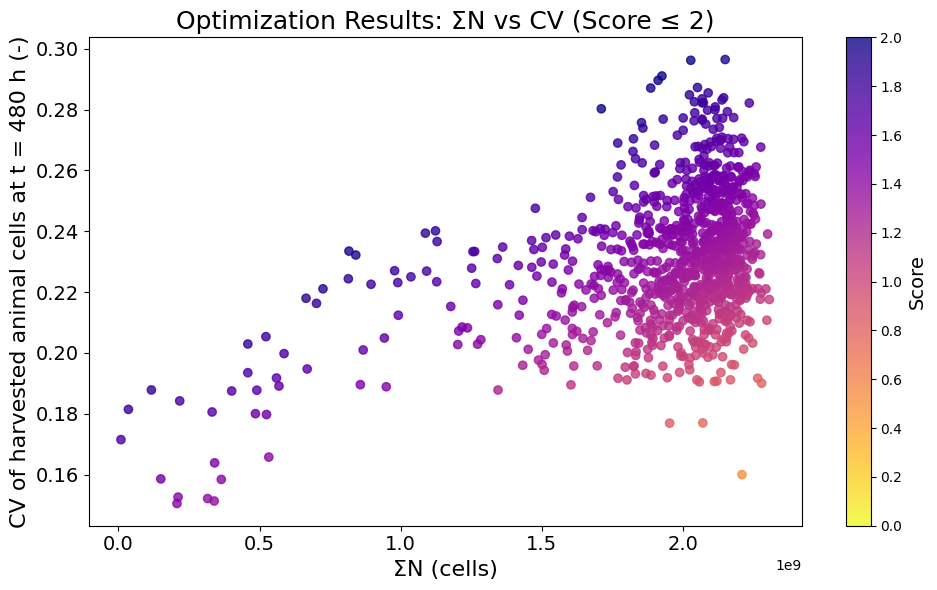

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize

# CSVファイルの読み込み（ファイルパスを適宜変更してください）
data = pd.read_csv('trials_results_lambda_2.csv')

# 必要な列を抽出
x = data['Y_value']  # x軸
y = data['Y_CV']     # y軸
scores = data['Score']  # 色分けに使用

# Scoreが2以下のデータをフィルタリング
mask = scores <= 2
x_filtered = x[mask]
y_filtered = y[mask]
scores_filtered = scores[mask]

# カラーマップ設定（"plasma_r" を使用してスコアが小さいほど黄色）
cmap = 'plasma_r'

# Normalizeの範囲を 0 ～ 2 に設定
norm = Normalize(vmin=0, vmax=2)

# プロットの準備
plt.figure(figsize=(10, 6))

# 散布図のプロット
scatter = plt.scatter(
    x_filtered, y_filtered,
    c=scores_filtered, cmap=cmap, norm=norm,
    alpha=0.8
)

# カラーバーの追加
cbar = plt.colorbar(scatter)
cbar.set_label('Score', fontsize=14)

# カラーバーの刻みを 0 ～ 2 の範囲で 0.2 刻みで設定
ticks = np.arange(0, 2.2, 0.2)  # 2.2 まで含めることで 2 を表示
cbar.set_ticks(ticks)
cbar.ax.set_yticklabels([f'{tick:.1f}' for tick in ticks])  # ラベルを小数1桁で整形

# 軸ラベルとタイトル
plt.xlabel('ΣN (cells)', fontsize=16)
plt.ylabel('CV of harvested animal cells at t = 480 h (-)', fontsize=16)
plt.title('Optimization Results: ΣN vs CV (Score ≤ 2)', fontsize=18)

# 軸目盛のフォントサイズ
plt.tick_params(axis='both', which='major', labelsize=14)

# グリッドを無効化
plt.grid(False)

# レイアウト調整
plt.tight_layout()

# グラフの表示
plt.show()

## Convergence of the score

### Graph

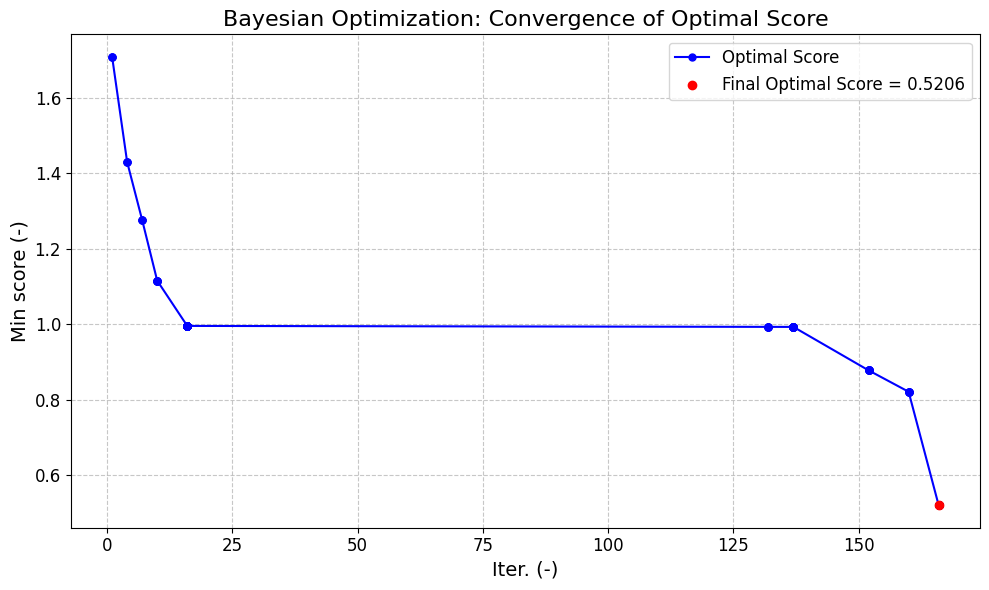

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# CSVファイルの読み込み（ファイルパスを適宜変更してください）
data = pd.read_csv('trials_results_lambda_2.csv')

# TrialとScore列を抽出
trials = data['Trial']
scores = data['Score']

# 最適解を保持するリスト
optimal_scores = []
optimal_trials = []

# 各試行ごとに最適解を記録
for trial in range(1, len(trials) + 1):
    best_score_idx = data[data['Trial'] <= trial]['Score'].idxmin()
    optimal_scores.append(data.loc[best_score_idx, 'Score'])
    optimal_trials.append(data.loc[best_score_idx, 'Trial'])

# プロットの準備
plt.figure(figsize=(10, 6))

# 最適解のみを線でつなげる
plt.plot(optimal_trials, optimal_scores, marker='o', linestyle='-', color='b', label='Optimal Score', markersize=5)

# 最適解の表示
optimal_score = min(optimal_scores)
optimal_trial = optimal_trials[optimal_scores.index(optimal_score)]
plt.scatter(optimal_trial, optimal_score, color='red', zorder=5, label=f'Final Optimal Score = {optimal_score:.4f}')

# 軸ラベルとタイトル
plt.xlabel('Iter. (-)', fontsize=14)
plt.ylabel('Min score (-)', fontsize=14)
plt.title('Bayesian Optimization: Convergence of Optimal Score', fontsize=16)

# 軸目盛のフォントサイズ
plt.tick_params(axis='both', which='major', labelsize=12)

# グリッドとレイアウト調整
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()

# グラフの表示
plt.show()

### File saving

In [ ]:
import pandas as pd


# ファイルを読み込む
file_path = "trials_results_lambda_2.csv"  # 添付ファイルの名前に置き換えてください
df = pd.read_csv(file_path)

# 必要な列を取得
trial_numbers = df['Trial']  # A列 (Trial番号)
scores = df['Score']         # H列 (Score)

# 最小値の追跡
min_score = float('inf')
result_list = []

for trial, score in zip(trial_numbers, scores):
    if score < min_score:
        min_score = score
        result_list.append((trial, min_score))

# 結果を出力
print("更新されたTrial番号とScoreのリスト:")
for trial, score in result_list:
    print(f"Trial: {trial}, Score: {score}")

# 結果をデータフレームに変換
result_df = pd.DataFrame(result_list, columns=['Trial', 'Score'])

# 結果をCSVに保存
output_file_path = "updated_scores.csv"  # 出力ファイル名
result_df.to_csv(output_file_path, index=False)

print(f"結果を '{output_file_path}' に保存しました。")

更新されたTrial番号とScoreのリスト:
Trial: 1, Score: 1.7078610594886132
Trial: 4, Score: 1.4294413066610483
Trial: 7, Score: 1.275717214475928
Trial: 10, Score: 1.1152928817720422
Trial: 16, Score: 0.9954473820053988
Trial: 132, Score: 0.9928417897359834
Trial: 137, Score: 0.9928013566166404
Trial: 152, Score: 0.8778885450433942
Trial: 160, Score: 0.8211994049842046
Trial: 166, Score: 0.5206476576167838
結果を 'updated_scores.csv' に保存しました。
